# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 01 : Évaluation  de la qualité des données

---

### Identité du document
* **Population cible** : NonResidential
* **Statut :** Phase 1 (exploration & prototypage)
* **Date de création :** 29 Décembre 2025
* **Dernière mise à jour :** 02 Janvier 2025
* **Dépendances notebooks** : Notebook 0

### Description
Effectuer un audit exhaustif de la qualité des données pour identifier les problèmes potentiels avant toute analyse approfondie. Cela permet d'éviter des biais dans les étapes ultérieures et de documenter un plan de nettoyage clair.

>**L'énoncé demande** de nous limiter aux batiments non-residentiel,ce point sera éxaminé dans la suite



### Objectifs principaux
1. **Cartographier** la complétude des données (analyse des NaN).
2. **Distinguer** les erreurs manifestes des valeurs extrêmes légitimes.
3. **Valider** la cohérence interne (logique métier et physique).
4. **Évaluer** l'impact du flag `DefaultData`.
5. **Produire** un plan d'action pour le nettoyage.

### Dépendances critiques
* `hydra` : Gestion de configuration.
* `pandas`, `seaborn`, `matplotlib` : Manipulation et inspection visuelle.
* `src.data_quality/` : Fonctions à construire.

### LIVRABLES
1. **Rapport de Qualité**  : Synthèse des constats.
2. **Matrice de Stratégie**  : Plan d'action ligne par ligne.
3. **Figures d'audit** : Preuves visuelles.

---

---
# Table des Matières
- [Section 0 : Importation et Restriction aux populations non-residentiel ](#section-0--importation-et-chargement)
- [Section 1 : Cartographie des valeurs manquantes](#section-1--où-sont-les-données-manquantes-et-pourquoi)
- [Section 2 : Diagnostic de cohérence et erreurs physiques](#section-2--les-valeurs-extrêmes-sont-elles-des-erreurs-ou-des-réalités)
- [Section 3 : Détection et analyse contextuelle des valeurs aberrantes](#section-3--les-données-respectent-elles-la-logique-physique-et-métier)
- [Section 4 : Analyse de fiabilité](#section-4--le-flag-defaultdata-compromet-il-la-fiabilité)
- [Section 5 : Analyse de doublons](#section-5--existe-t-il-des-doublons-ou-des-quasi-doublons)
- [Section 6 : Plan d'action](#section-6--quelle-stratégie-de-nettoyage-adopter)

---

# Section 0 : Importation et Restriction aux populations non-residentiel 

## Importation des packages

In [31]:
import logging
import pandas as pd
from pathlib import Path


# Import des fonctions utilitaires 

import sys

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


from data.load_data import load_data_raw
from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger

# graphique package
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np

# statistiques
from scipy.stats import chi2_contingency
from scipy import stats

# regex pour netoiyer nom colonne (exportation)
import re

 


## init config et chargement

In [32]:
# Chargement de la configuration principale (Hydra)
cfg = load_config()

# Initialisation du logger
setup_eda_logger(cfg)
logger = logging.getLogger(__name__)

# Création des dossiers nécessaires à l'exécution (raw, interim, processed, reports, etc.)
create_directories(cfg)
# Chargement des données brutes

# Forcer pandas à afficher toutes les colonnes
pd.set_option("display.max_columns", None)

# Forcer pandas à afficher toutes les lignes (si besoin)
pd.set_option("display.max_rows", None)

# Forcer pandas à afficher toute la largeur (évite les "...")
pd.set_option("display.width", None)



df_raw = load_data_raw(cfg)

# Validation dimensions
n_rows, n_cols = df_raw.shape
logger.info(f"Dataset chargé ({n_rows} lignes, {n_cols} colonnes)")

# Premier aperçu
df_raw.sample(5)


2026-01-03 21:23:21,552 - utils.config_loader - INFO - Configuration 'config' chargée (project_root=C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2)
2026-01-03 21:23:21,567 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\raw
2026-01-03 21:23:21,567 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\interim
2026-01-03 21:23:21,567 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\processed
2026-01-03 21:23:21,567 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\figures
2026-01-03 21:23:21,567 - utils.config_loader - INFO - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\reports
2026-01-03 21:23:21,599 - data.load_data - INFO - DataFrame chargé : 3376 lignes, 46 colonnes
2026-01-0

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1993,24086,2016,Campus,Other,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,1333 AIRPORT WAY S,Seattle,WA,98134.0,7666203387,2,GREATER DUWAMISH,47.59042,-122.32498,1991,10.0,0,230971,0,230971,"Other, Parking",Other,230970.0,Parking,0.0,NaN,NaN,NaN,NaN,91.000000,96.199997,235.100006,242.199997,2.102229e+07,2.223084e+07,0.0,4.519276e+06,15419770.0,56025.152340,5602515.0,False,NaN,Compliant,NaN,405.05,1.75
1162,21129,2016,NonResidential,Retail Store,Dubliner Building,3515 Fremont Ave N,Seattle,WA,98103.0,1972203060,6,LAKE UNION,47.65115,-122.35024,1911,1.0,2,20516,0,20516,"Hotel, Retail Store",Retail Store,10155.0,Hotel,8000.0,NaN,NaN,NaN,98.0,56.299999,61.099998,89.599998,93.300003,1.021797e+06,1.109483e+06,0.0,7.766250e+04,264984.0,7568.120605,756812.0,False,NaN,Compliant,NaN,42.04,2.05
650,19459,2016,Multifamily LR (1-4),Low-Rise Multifamily,Raleigh Court Apartments,3418 NE 65th St,Seattle,WA,98115.0,0425049065,4,NORTHEAST,47.67602,-122.29059,1998,1.0,3,27160,3223,23937,"Multifamily Housing, Office, Parking",Multifamily Housing,20148.0,Parking,3233.0,Office,3024.0,NaN,NaN,29.400000,30.400000,92.300003,95.300003,6.813542e+05,7.035904e+05,0.0,1.996935e+05,681354.0,0.000000,0.0,False,NaN,Compliant,NaN,4.75,0.17
605,807,2016,NonResidential,Large Office,645 Elliott - North Building,645 Elliott Avenue West,Seattle,WA,98119.0,3879902265,7,MAGNOLIA / QUEEN ANNE,47.62520,-122.36737,2008,1.0,4,242686,100176,142510,"Office, Parking",Office,149081.0,Parking,76364.0,NaN,NaN,2017,77.0,65.000000,65.000000,204.000000,204.000000,9.683979e+06,9.683979e+06,0.0,2.838212e+06,9683978.0,0.000000,0.0,False,NaN,Compliant,NaN,67.51,0.28
1739,23288,2016,Multifamily LR (1-4),Low-Rise Multifamily,CLARWOOD,805 Marion St,Seattle,WA,98104.0,8590400865,3,EAST,47.60733,-122.32727,1920,1.0,4,24900,0,24900,Multifamily Housing,Multifamily Housing,24900.0,NaN,NaN,NaN,NaN,NaN,68.0,75.199997,83.099998,103.800003,112.099998,1.872279e+06,2.069689e+06,0.0,8.674520e+04,295975.0,15763.040040,1576304.0,False,NaN,Compliant,NaN,85.78,3.44


## Restriction aux populations non-residentiel 


### Objectif et mission  
![Objectif et mission](../figures/notebook_1/00_Objectif_Mission.png)  


L’objectif de ce projet est de prédire les émissions de CO₂ des bâtiments **non résidentiels**.

Ce périmètre est directement imposé par la problématique métier et par le cadre réglementaire du jeu de données. Les bâtiments résidentiels et non résidentiels obéissent à des logiques d’usage, de consommation énergétique et de production d’émissions fondamentalement différentes. Les analyser conjointement introduirait une hétérogénéité structurelle incompatible avec un objectif de modélisation robuste.

La population cible du projet est définie à partir de la variable `BuildingType`, issue du système officiel de déclaration énergétique (Portfolio Manager). Cette variable permet de distinguer les bâtiments résidentiels des bâtiments non résidentiels et sert de base au filtrage appliqué dans la suite du projet.

Le choix est fait de restreindre l’analyse aux bâtiments non résidentiels dès les premières étapes, avant l’analyse exploratoire détaillée et les opérations de nettoyage. Ce filtrage précoce vise à garantir la cohérence statistique des analyses, la comparabilité des indicateurs énergétiques et la validité des relations étudiées entre les variables explicatives et les émissions de CO₂.

La variable `BuildingType` étant une variable catégorielle administrative, son éventuelle imperfection ne peut être corrigée de manière fiable sans expertise métier approfondie. Elle est donc considérée suffisamment fiable pour définir la population d’étude à l’échelle globale du jeu de données. Les erreurs marginales de classification, si elles existent, sont supposées avoir un impact limité par rapport aux biais qu’introduirait le mélange des populations résidentielles et non résidentielles.

> **Ce choix méthodologique est assumé et conservé tout au long du projet.**



In [33]:
df_raw["BuildingType"].unique().tolist()



['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Campus',
 'Multifamily LR (1-4)',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [34]:
df_raw["BuildingType"].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [35]:
residential_types = [
    "Multifamily MR (5-9)",
    "Multifamily HR (10+)",
    "Multifamily LR (1-4)"
]

df_raw = df_raw[~df_raw["BuildingType"].isin(residential_types)].copy()
df_raw.shape

(1668, 46)

In [36]:
df_raw["BuildingType"].value_counts()

BuildingType
NonResidential        1460
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: count, dtype: int64

# Section 1 : Cartographie des valeurs manquantes

**Objectif :** Quantifier et visualiser les valeurs manquantes pour identifier les patterns et mécanismes sous-jacents. Cela aide à évaluer la complétude du dataset et à anticiper les biais.

Population :Les batiments non-résidentiel

## Calcul des pourcentages de NaN

Nous calculons le % de NaN par colonne et trions par ordre décroissant.
Colonnes avec >50% de NaN sont candidates à suppression.

In [37]:
# df_raw['Comments'].isnull()

In [38]:
# Calcul des NaN
missing_perc = df_raw.isnull().mean() * 100 # mean() calcule la proportion de NaN par colonne
missing_df = pd.DataFrame({'Column': missing_perc.index, '% Missing': missing_perc.values})
missing_df = missing_df.sort_values(by='% Missing', ascending=False).reset_index(drop=True)

logger.info("Colonnes avec le plus de NaN :")
display(missing_df.head(30))

# Identification colonnes >50% NaN
high_missing = missing_df[missing_df['% Missing'] > 50]
logger.info(f"Colonnes avec >50% NaN : {high_missing['Column'].tolist()}")

2026-01-03 21:23:21,754 - __main__ - INFO - Colonnes avec le plus de NaN :


,Column,% Missing
0,Comments,100.000000
1,Outlier,98.980815
2,YearsENERGYSTARCertified,94.124700
3,ThirdLargestPropertyUseType,78.836930
4,ThirdLargestPropertyUseTypeGFA,78.836930
5,SecondLargestPropertyUseType,48.741007
6,SecondLargestPropertyUseTypeGFA,48.741007
7,ENERGYSTARScore,34.412470
8,ZipCode,0.959233
9,LargestPropertyUseType,0.359712


2026-01-03 21:23:21,766 - __main__ - INFO - Colonnes avec >50% NaN : ['Comments', 'Outlier', 'YearsENERGYSTARCertified', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']


> techniquement ([pandas.isnull()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html)) permet de detecter la plus part des valeurs manquantes,si on en oubli certains ,great expectation pourra les détecter

On constate que beaucoup de variables ont des valeurs manquantes, notamment 8 colonnes critiques qui dépassent les 33 % de NAN. Les variables `Comments`, `Outlier` et `YearsENERGYSTARCertified` sont quasiment inexistantes (entre 94 % et 100 % de manque), ce qui les rend statistiquement inexploitables.Toute fois `Outlier` est interessant car elle indique si un batiment est suspecté Outlider ou pas donc peux servir à la section 3.

De même, les données liées aux usages secondaires et tertiaires des bâtiments présentent des taux de NA massifs, révélant que la majorité des structures déclarées n'ont qu'une seule activité principale ou que ces informations n'ont pas été jugées nécessaires lors de la saisie.

Le **ENERGYSTARScore** constitue un point de vigilance majeur avec environ 33 % de données manquantes.

À l'inverse, on peut noter que les variables comme la consommation réelle d'énergie et les émissions de gaz à effet de serre sont assez robustes, avec moins de 1 % de NA. Cette solidité sur les indicateurs de performance réels garantit que, malgré l'élimination nécessaire des colonnes lacunaires, le cœur du dataset restera parfaitement fiable en vue de la modélisation.

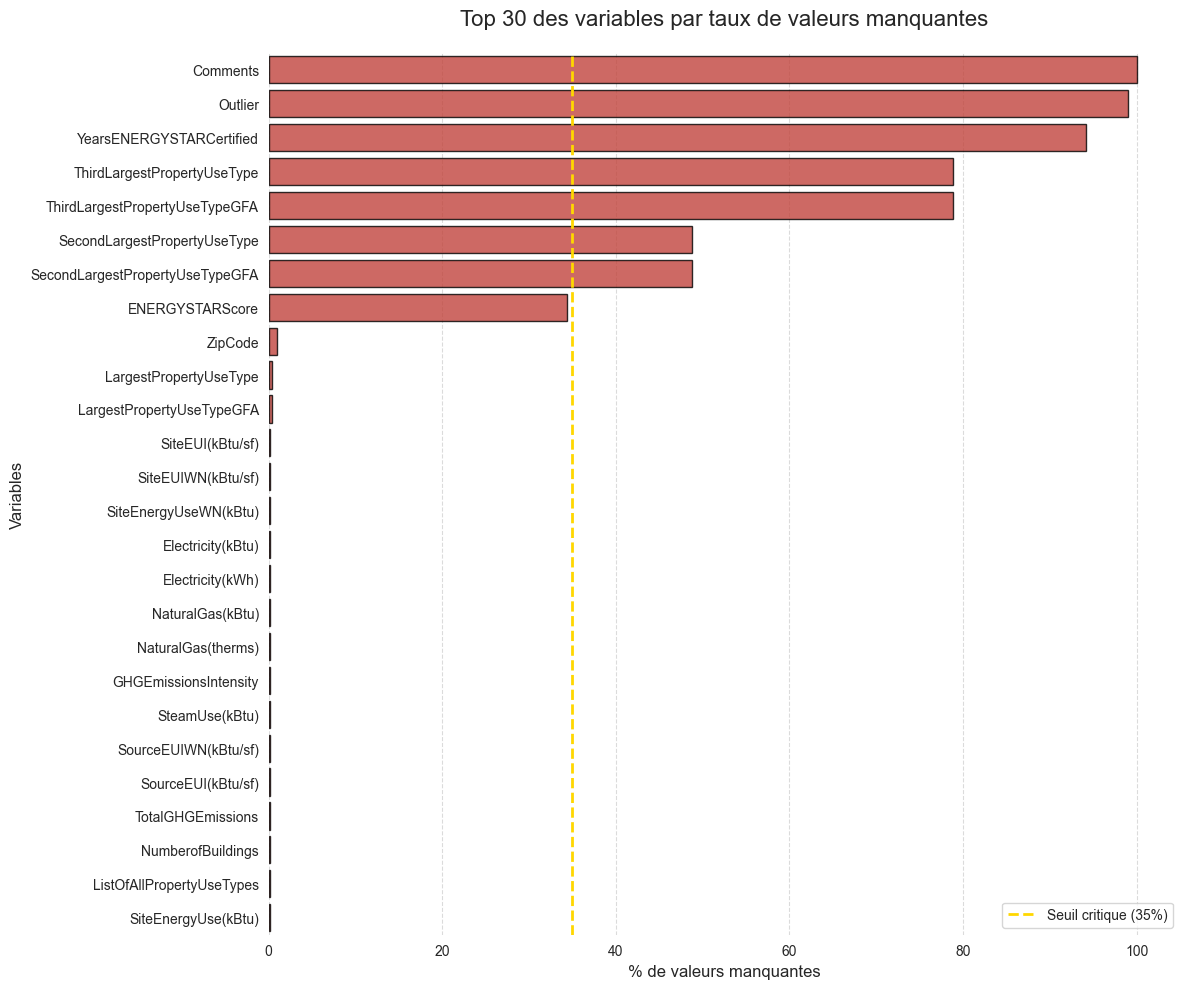

2026-01-03 21:23:22,729 - __main__ - INFO - Graphique des NA : ../figures/notebook_1/01_data_NA_bar.png


In [39]:
# Graphique

# Filtrage pour ne garder que les colonnes ayant des valeurs manquantes
missing_data_plot = missing_df[missing_df['% Missing'] > 0].head(30)

# Création du graphique
plt.figure(figsize=(12, 10))
sns.set_style("white")

# 
barplot = sns.barplot(
    data=missing_data_plot, 
    x='% Missing', 
    y='Column', 
    color='#d73027',
    edgecolor='black',
    alpha=0.8
)

# Ajout d'une ligne de seuil à 35% 
plt.axvline(x=35, color='gold', linestyle='--', linewidth=2, label='Seuil critique (35%)')

# Personnalisation
plt.title('Top 30 des variables par taux de valeurs manquantes', fontsize=16, pad=20)
plt.xlabel('% de valeurs manquantes', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.legend(loc='lower right', frameon=True)

# Ajout d'une grille légère sur l'axe X uniquement
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

# Exportation du graphique
plt.tight_layout()
plt.savefig('../figures/notebook_1/01_data_NA_bar.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info("Graphique des NA : ../figures/notebook_1/01_data_NA_bar.png")

## Visualisation : Heatmap de missingness

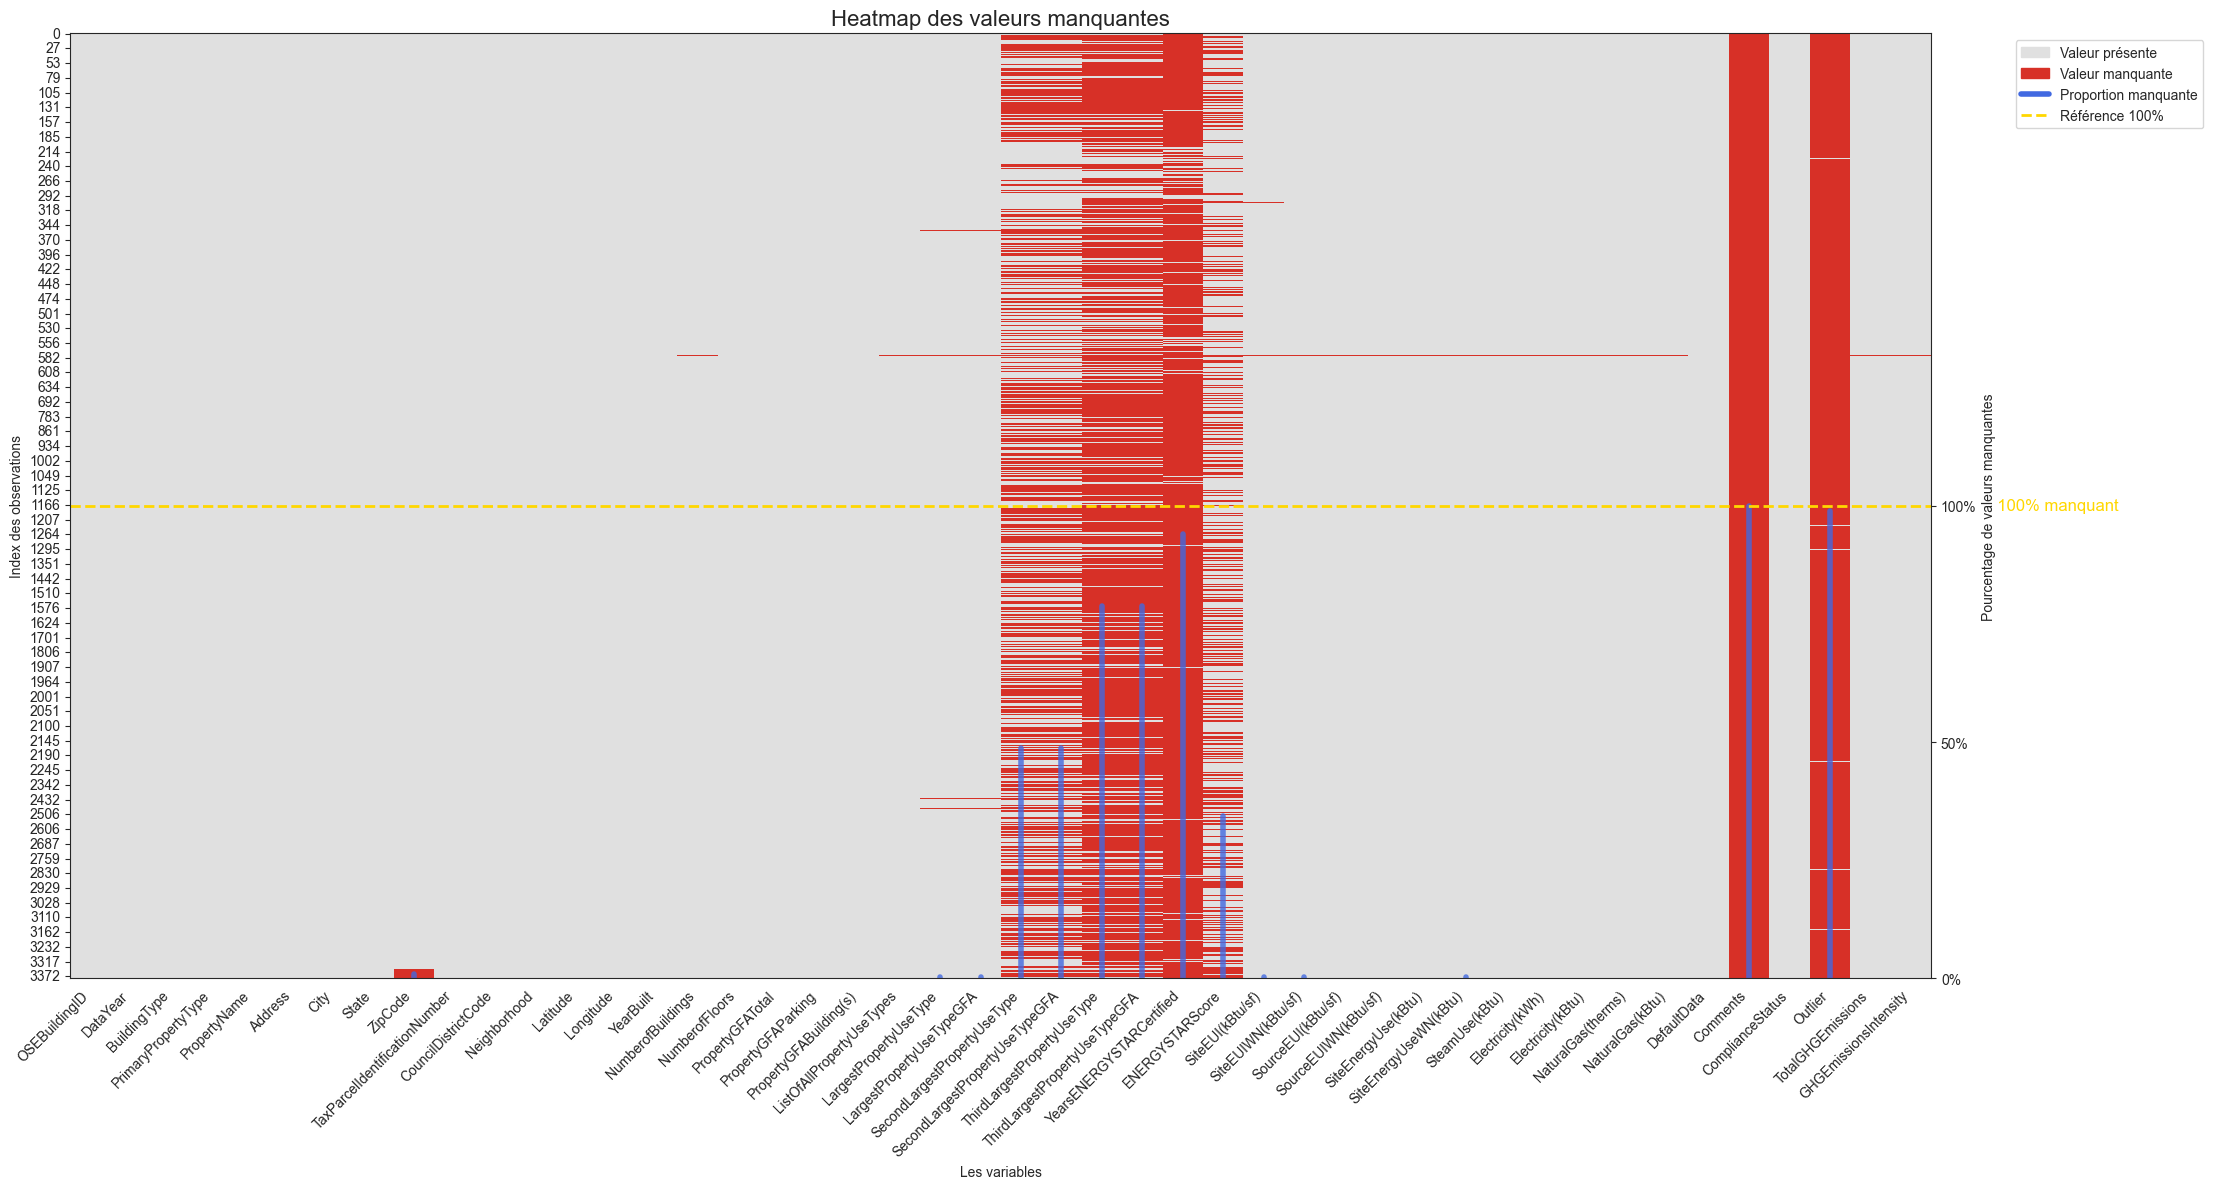

In [40]:

# Calcul du pourcentage de valeurs manquantes par colonne
missing_ratio = df_raw.isnull().mean()

plt.figure(figsize=(22, 12))

# Heatmap binaire
ax = sns.heatmap(df_raw.isnull(),
                 cbar=False,
                 cmap=['#e0e0e0', '#d73027'])  # gris = présent, rouge = manquant

# Titre et axes
plt.title('Heatmap des valeurs manquantes', fontsize=16)
plt.xlabel("Les variables")
plt.ylabel("Index des observations")
plt.xticks(rotation=45, ha='right')

# Ajout des barres verticales
n_rows = len(df_raw)
for i, ratio in enumerate(missing_ratio):
    bar_height = ratio * (n_rows * 0.5)  # 100% correspond à la moitié de l'axe
    ax.plot([i+0.5, i+0.5],
            [n_rows, n_rows - bar_height],
            color='royalblue', linewidth=4, alpha=0.8)

# Ligne jaune pour indiquer la barre des 100% manquants
ax.axhline(y=n_rows - n_rows*0.5, color='gold', linestyle='--', linewidth=2)
ax.text(len(missing_ratio)+0.5, n_rows - n_rows*0.5, "          100% manquant", 
        color='gold', va='center', fontsize=12)

# Axe des pourcentages à gauche
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel("Pourcentage de valeurs manquantes")
ax2.set_yticks([n_rows, n_rows - n_rows*0.25, n_rows - n_rows*0.5])
ax2.set_yticklabels(["0%", "50%", "100%"])

# Légende 
present_patch = mpatches.Patch(color='#e0e0e0', label='Valeur présente')
missing_patch = mpatches.Patch(color='#d73027', label='Valeur manquante')
line_patch = Line2D([0], [0], color='royalblue', linewidth=4, label='Proportion manquante')
ref_patch = Line2D([0], [0], color='gold', linestyle='--', linewidth=2, label='Référence 100%')
plt.legend(handles=[present_patch, missing_patch, line_patch, ref_patch],
           loc='upper right',
           bbox_to_anchor=(1.15, 1),
           frameon=True)

plt.tight_layout()
plt.savefig('../figures/notebook_1/02_quality_missing_heatmap.png',
            dpi=300, bbox_inches='tight')
plt.show()


Même observations que précédement

## Analyse diagnostique des mécanismes de données manquantes par colonne

L'objectif de cette section est de déterminer le mécanisme sous-jacent (MCAR, MAR ou MNAR) afin de choisir la stratégie de traitement appropriée. Selon la littérature, nous distinguons trois mécanismes fondamentaux :

- MCAR (Missing Completely At Random) : La probabilité qu'une donnée manque est indépendante de toute valeur, observée ou non. La suppression n'introduit pas de biais.

- MAR (Missing At Random) : L'absence dépend de variables observées. Exemple : Les bâtiments anciens (YearBuilt) rapportent moins souvent leur score Energy Star. L'imputation conditionel est ici recommandée.

- MNAR (Missing Not At Random) : L'absence dépend de la valeur manquante elle-même. Exemple : Un propriétaire ne déclare pas sa consommation car elle est anormalement élevée. Ce cas est le plus complexe et nécessite souvent une modélisation spécifique.
Source :https://bookdown.org/mike/data_analysis/diagnosing-the-missing-data-mechanism.html

### Matrice de corrélation

Nous utilisons d'abord une matrice de corrélation pour identifier les dépendances structurelles (variables qui manquent systématiquement ensemble).

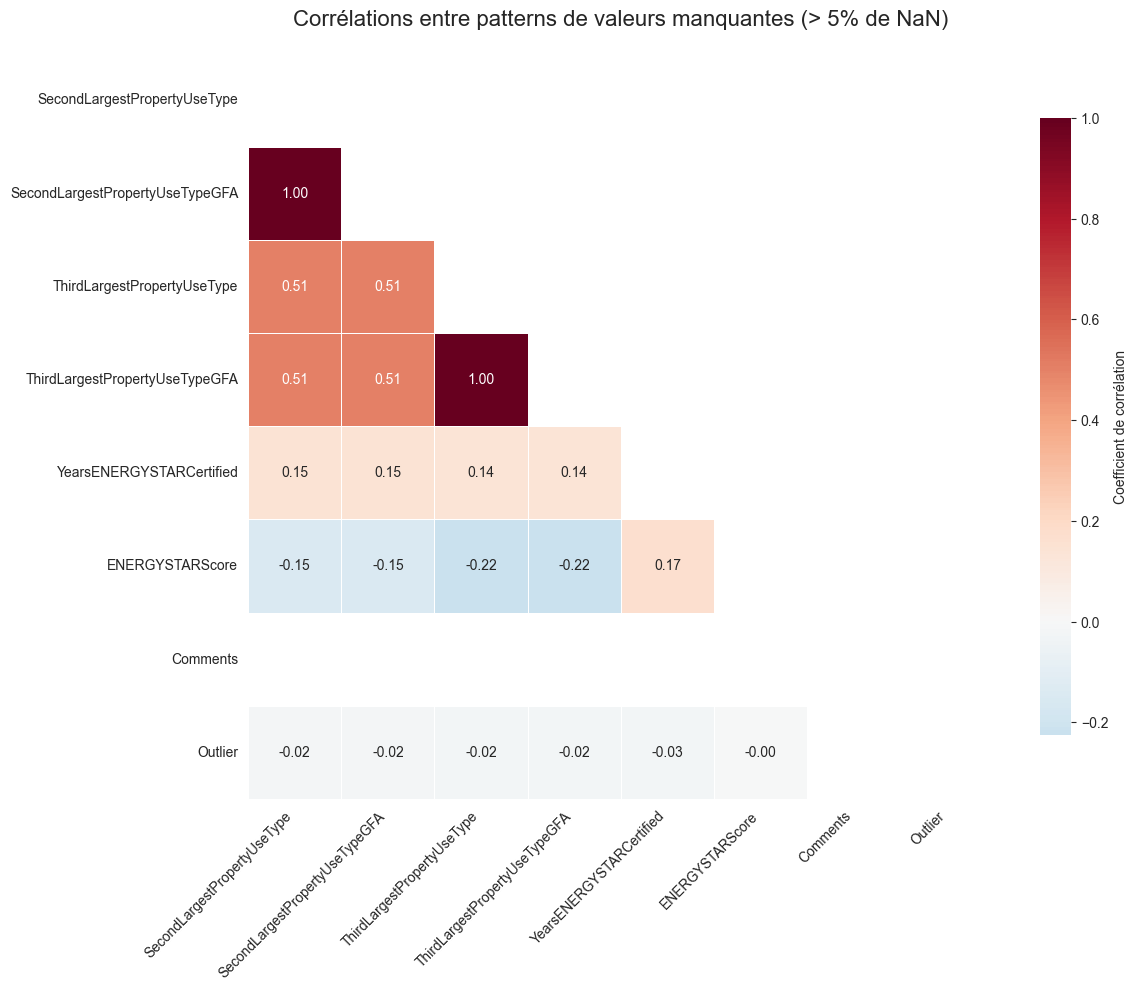

In [41]:
# Sélection des colonnes ayant plus de 5% de valeurs manquantes
threshold = 0.05
missing_rates = df_raw.isnull().mean()
cols_with_missing = missing_rates[missing_rates > threshold].index.tolist()

if len(cols_with_missing) > 1: # Afin de pouvoir tester differents valeurs de threshold
    # Calcul de la corrélation
    missing_corr = df_raw[cols_with_missing].isnull().corr()

    # Masque triangulaire pour la lisibilité
    mask = np.triu(np.ones_like(missing_corr, dtype=bool))

    plt.figure(figsize=(12, 10))

    # RdBu_r : Rouge pour corrélation positive , Bleu pour négative
    sns.heatmap(missing_corr,
                cmap='RdBu_r', 
                center=0,
                annot=True,
                fmt=".2f",
                mask=mask,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8, "label": "Coefficient de corrélation"})

    plt.title('Corrélations entre patterns de valeurs manquantes (> 5% de NaN)', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Exportation
    plt.savefig('../figures/notebook_1/03_quality_missing_corr.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Pas assez de variables significatives pour établir une matrice de corrélation.")


---

### Diagnostic et stratégie de traitement des valeurs manquantes

L'analyse des NA est une étape charnière pour orienter notre stratégie de modélisation. Le tableau suivant récapitule les variables présentant plus de 5% de valeurs manquantes, en y intégrant les taux réels observés dans notre diagnostic technique.

#### Tableau des variables à forte proportion de NaNs (> 5%)

| Colonne | Taux de NaNs | Description | Décision & Recommandation |
| --- | --- | --- | --- |
| **Comments** | 100% | Commentaires libres des agents. | **Suppression immédiate**. Aucun apport pour la modélisation. |
| **Outlier** | 98.99% | Signalement des valeurs atypiques. | **Utilisation pour le diagnostic** puis suppression avant l'entraînement. |
| **YearsENERGYSTARCertified** | 94.26% | Historique des certifications. | **Suppression**. La densité de données est trop faible pour être exploitable. |
| **ThirdLargestPropertyUseType** (et GFA) | 78.18% | Troisième usage du bâtiment. | **Suppression**. Concerne moins d'un bâtiment sur cinq ; risque de sur-apprentissage. |
| **SecondLargestPropertyUseType** (et GFA) | 47.75% | Deuxième usage du bâtiment. | **Transformation binaire** |
| **ENERGYSTARScore** | 33.01% | Note de performance globale. | **Variable critique**. Nécessite un exament. |

---

### Analyse de la matrice de corrélation des manquants

L'examen de la matrice de corrélation des patterns de valeurs manquantes (heatmap) permet de dégager des logiques de remplissage qui ne sont pas dues au hasard.

Le résultat le plus frappant est la corrélation de 1.00 entre les types d'usages (SecondLargestPropertyUseType) et leurs surfaces respectives (GFA). Cette relation parfaite indique que le dataset est exempt d'erreurs de saisie contradictoires sur ce point : dès qu'un usage est déclaré, sa surface l'est aussi, et inversement. On ne parle pas ici d'une perte d'information accidentelle, mais d'une absence structurelle. Si la donnée est absente, c'est que l'usage n'existe pas. Cette observation justifie scientifiquement notre choix de transformer ces colonnes en indicateurs binaires.

On observe une corrélation modérée de 0.51 entre l'absence d'un second usage et celle d'un troisième. Cela confirme une structure "en entonnoir" : la présence d'un troisième usage est conditionnée par l'existence d'un second. Cette dépendance statistique suggère que la mixité des bâtiments suit une progression logique. Plus un bâtiment est complexe (usage 3), plus il est probable qu'il ait déjà été identifié comme mixte (usage 2).

La variable ENERGYSTARScore présente des coefficients très faibles (entre -0.14 et -0.22) avec les autres variables de surface. Contrairement aux usages secondaires, l'absence du score n'est pas dictée par la structure physique ou la complexité du bâtiment. Un bâtiment très simple peut ne pas avoir de score, tout comme un gratte-ciel complexe.Nous examinerons son cas.

Enfin, les variables Outlier et Comments montrent des corrélations proches de 0.00 avec tout le reste du dataset. Cela confirme que ces colonnes sont remplies (ou plutôt vidées) de manière totalement indépendante du reste des caractéristiques techniques. À plus de 99% de vide, elles représentent un bruit inutile pour nos futurs modèles.

---

### Synthèse et orientations :

- L'absence de données sur les usages secondaires étant informative (bâtiment mono-usage), nous allons créer la feature IsMixedUse. Cela permet de conserver l'essence de l'information sans gérer des colonnes à moitié vides.
- Puisque le ENERGYSTARScore ne suit pas le pattern des autres manquants, nous ne pouvons pas le binariser. Nous allons l'étudier de plus près pour une imputation précise.
- Les colonnes à corrélation nulle ou trop lacunaires  seront écarté dans le modéle

---
### Problématique:
- **Cas MCAR (Missing Completely At Random)** :  
  Si le score ENERGY STAR manque de manière totalement aléatoire, nous pouvons supprimer les lignes ou appliquer une imputation simple sans introduire de biais majeur.

- **Cas MAR (Missing At Random)** :  
  Si l'absence du score est liée à une variable observée (par exemple le type de bâtiment, la certification ou la taille), alors une suppression naïve introduirait un biais. Dans ce cas, il faut envisager des méthodes d’imputation conditionnelles.

- **Cas MNAR (Missing Not At Random)** :  
  Si le score manque parce que la valeur elle-même est problématique (par exemple, les bâtiments très énergivores ne déclarent pas leur score), alors l’absence est informative. Il faut adapter l’analyse : création d’indicateurs de "valeur manquante", modèles spécifiques, ou acceptation de limites dans l’interprétation.

---

Avant de traiter les valeurs manquantes, il est indispensable de tester la dépendance entre l’absence du `ENERGYSTARScore` et les autres variables.  
- Si l’absence est aléatoire (MCAR), une suppression est envisageable.  
- Si elle est conditionnelle (MAR), une imputation basée sur les variables corrélées est nécessaire.  
- Si elle est non aléatoire (MNAR), l’absence elle-même devient une information à intégrer dans le modèle.  


### Test du mécanisme MAR

Pour diagnostiquer si nous sommes en présence d'un mécanisme MAR, nous vérifions si l'absence du ENERGYSTARScore est corrélée au type de bâtiment(pertinent pour des raison de comprehension métier). Si la distribution des manquants varie selon le BuildingType, cela prouve que l'absence est conditionnelle et non aléatoire.

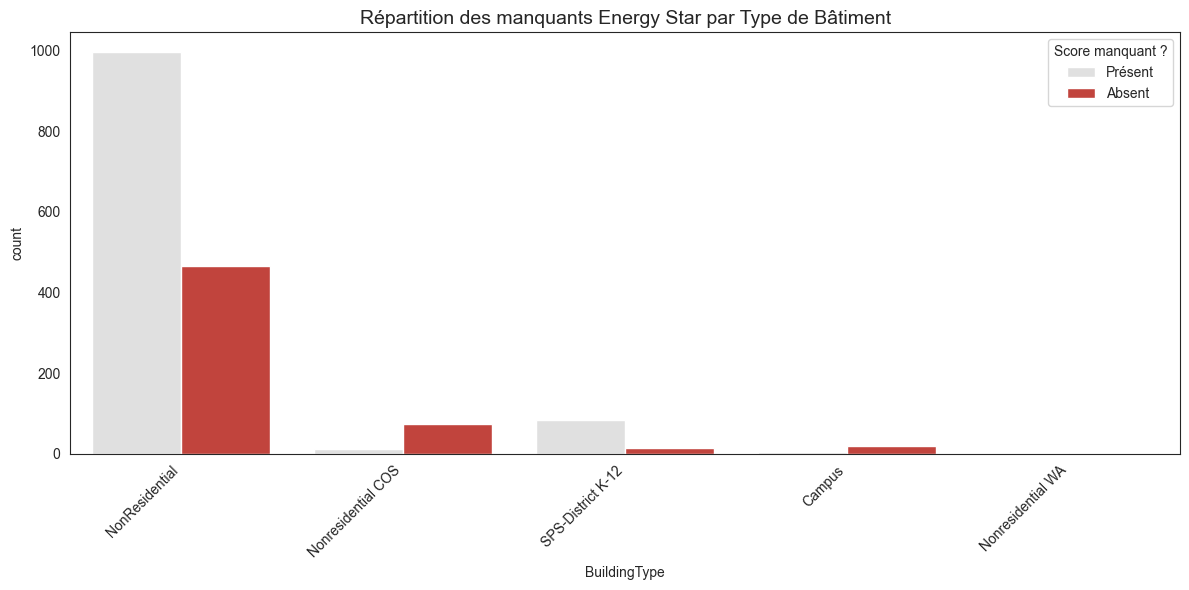

2026-01-03 21:23:26,444 - __main__ - INFO - Test du Chi² - p-value: 6.3802e-31


Résultat du test du Chi² : p-value = 6.3802e-31


In [42]:
# Préparation des données
df_raw['ENERGYSTARScore_is_missing'] = df_raw['ENERGYSTARScore'].isnull()

# Visualisation
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_raw, x='BuildingType', hue='ENERGYSTARScore_is_missing', palette=['#e0e0e0', '#d73027'])
plt.title('Répartition des manquants Energy Star par Type de Bâtiment', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score manquant ?', labels=['Présent', 'Absent'])
plt.tight_layout()
plt.savefig('../figures/notebook_1/03_energystar_missing_by_buildingtype.png')
plt.show()

# Test Statistique du Chi2
contingency_table = pd.crosstab(df_raw['BuildingType'], df_raw['ENERGYSTARScore_is_missing'])
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

logger.info(f"Test du Chi² - p-value: {p_val:.4e}")
print(f"Résultat du test du Chi² : p-value = {p_val:.4e}")

---

### Analyse de la répartition des manquants par Type de Bâtiment

Le graphique de répartition souligne une hétérogénéité structurelle flagrante dans la disponibilité du ENERGYSTARScore. Alors que les bâtiments de type NonResidential affichent une présence massive de scores malgré un volume de manquants significatif, d'autres catégories comme Nonresidential COS ou Campus présentent un profil critique où les données absentes sont largement majoritaires par rapport aux données présentes. À l'opposé, les établissements de type SPS-District K-12 semblent bénéficier d'un suivi bien plus complet.

Le test du Chi2 indique une p-value de 6.38×10−31. Ce résultat rejette largement l'hypothèse d'indépendance et confirme que nous sommes face à un mécanisme de données manquantes MAR (Missing At Random).l'absence du score n'est pas accidentelle mais directement conditionnée par la catégorie du bâtiment.


### Implications pour la stratégie de traitement

#### Rejet de la suppression pure et simple

Si nous avions supprimé toutes les lignes où le score est manquant (soit plus de 30% du dataset), nous n'aurions pas simplement perdu du volume de données, nous aurions introduit un biais de sélection. Comme l'absence est corrélée au BuildingType, supprimer ces lignes reviendrait à effacer presque intégralement certaines catégories (comme les Campus ou les Nonresidential COS) de notre analyse. Notre modèle final serait incapable de généraliser correctement pour ces types de bâtiments, car il n'aurait appris que sur les catégories "bons élèves" en matière de reporting.
#### Justification de l'imputation par groupe

Puisque la probabilité de manquance dépend de variables observées (ici le type de bâtiment), la théorie statistique nous autorise à compenser ces vides en utilisant l'information contenue dans ces mêmes variables. Imputer par groupe permet de :

    Maintenir la variance inter-groupe : En utilisant la médiane spécifique à chaque catégorie, nous respectons les différences de performance énergétique inhérentes à chaque usage (un entrepôt n'a pas la même distribution de score qu'un bureau).

    Réduire l'erreur d'estimation : Une imputation globale (moyenne/médiane de tout le dataset) aurait "écrasé" les spécificités de chaque métier, créant des données synthétiques déconnectées de la réalité physique des bâtiments.

#### Choix de la Médiane vs Moyenne

Nous privilégions la médiane au sein de chaque groupe pour son caractère robuste. Le ENERGYSTARScore est une note de 1 à 100 qui ne suit pas forcément une loi normale au sein de chaque catégorie. La moyenne est vulnérable aux valeurs extrêmes (un bâtiment exceptionnellement performant ou médiocre) qui pourraient tirer la valeur imputée vers un niveau non représentatif du "bâtiment typique" du groupe. La médiane nous assure que la valeur de remplacement est la plus centrale et la plus probable.

#### Cas particuliers et limites

Il faut rester vigilant : bien que le test valide le mécanisme MAR par rapport au BuildingType, il se peut qu'au sein d'une même catégorie, l'absence soit liée à la performance elle-même (ex: un propriétaire ne déclare pas son score car il sait qu'il est mauvais). C'est le risque du Missing Not At Random. Pour limiter ce risque, nous pourrons, lors de la phase de modélisation, créer une variable binaire Has_EnergyStarScore qui permettra au modèle de capter si l'absence d'information est, en soi, un signal prédictif de la consommation.


## Analyse des lignes avec taux élevé de NA

Après avoir diagnostiqué les variables, nous examinons si certains bâtiments présentent un déficit de données tel qu'ils pourraient nuire à la fiabilité de nos futurs modèles. Une ligne avec trop de valeurs manquantes est souvent le signe d'un défaut majeur lors de la déclaration

In [43]:
# Calcul du % de NA par ligne
row_missing_pct = df_raw.isnull().mean(axis=1) * 100

# Statistiques descriptives
print(" ANALYSE DES LIGNES PAR TAUX DE NA")
print("="*70)
print(f"Moyenne : {row_missing_pct.mean():.2f}%")
print(f"Médiane : {row_missing_pct.median():.2f}%")
print(f"Q1 (25%) : {row_missing_pct.quantile(0.25):.2f}%")
print(f"Q3 (75%) : {row_missing_pct.quantile(0.75):.2f}%")
print(f"Max : {row_missing_pct.max():.2f}%")
print()

# Comptage par seuil
thresholds = [10, 15, 20, 25,30,50]
for t in thresholds:
    n_above = (row_missing_pct > t).sum()
    pct_above = n_above / len(df_raw) * 100
    print(f"Lignes avec >{t}% NA : {n_above:,} ({pct_above:.2f}%)")

 ANALYSE DES LIGNES PAR TAUX DE NA
Moyenne : 12.48%
Médiane : 12.77%
Q1 (25%) : 10.64%
Q3 (75%) : 14.89%
Max : 53.19%

Lignes avec >10% NA : 1,283 (76.92%)
Lignes avec >15% NA : 221 (13.25%)
Lignes avec >20% NA : 4 (0.24%)
Lignes avec >25% NA : 2 (0.12%)
Lignes avec >30% NA : 2 (0.12%)
Lignes avec >50% NA : 2 (0.12%)


In [44]:
# Lignes avec entre 10% et 15% de NA
rows_between_10_15 = df_raw[(row_missing_pct >= 10) & (row_missing_pct <= 15)]

print(f"Lignes avec entre 10% et 15% de NA : {len(rows_between_10_15)}")
display(rows_between_10_15.sample(n=min(4, len(rows_between_10_15)), random_state=42))


Lignes avec entre 10% et 15% de NA : 1062


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore_is_missing
57,77,2016,NonResidential,Hotel,Comfort Suites Seattle Center,601 Roy St,Seattle,WA,98109.0,2249000170,7,MAGNOLIA / QUEEN ANNE,47.62519,-122.34456,1999,1.0,4,122942,44891,78051,"Hotel, Parking",Hotel,78051.0,Parking,44891.0,NaN,NaN,NaN,94.0,68.400002,69.000000,136.699997,138.699997,5337334.00,5387530.0,0.0,7.103545e+05,2423730.0,29136.039060,2913604.0,False,NaN,Compliant,NaN,171.64,1.40,False
895,20167,2016,NonResidential,K-12 School,Ninth & Lenora Building,2030 9th Avenue,Seattle,WA,98121.0,0660001310,7,DOWNTOWN,47.61718,-122.33654,1957,1.0,2,21600,0,21600,K-12 School,K-12 School,21600.0,NaN,NaN,NaN,NaN,NaN,72.0,58.400002,65.500000,120.300003,127.800003,1261536.75,1415640.0,0.0,1.786998e+05,609724.0,6518.130371,651813.0,False,NaN,Compliant,NaN,38.87,1.80,False
1268,21397,2016,NonResidential,Retail Store,Guitar Center (Block 38W) - SEDO,520-530 Westlake Ave. North,Seattle,WA,98109.0,1983200180,7,LAKE UNION,47.62399,-122.33804,1964,1.0,2,45271,0,45271,Retail Store,Retail Store,45271.0,NaN,NaN,NaN,NaN,NaN,57.0,56.400002,64.300003,112.199997,119.099998,2553763.50,2912179.5,0.0,3.361235e+05,1146853.0,14069.100590,1406910.0,False,NaN,Compliant,NaN,82.72,1.83,False
2896,27378,2016,NonResidential,Supermarket / Grocery Store,Safeway 1550 - Roosevelt Way,7300 Roosevelt Way NE,Seattle,WA,98115.0,6716700415,4,NORTHEAST,47.68217,-122.31675,1997,1.0,1,76585,38585,38000,"Parking, Supermarket/Grocery Store",Supermarket/Grocery Store,41447.0,Parking,0.0,NaN,NaN,NaN,18.0,335.500000,346.700012,761.299988,773.099976,13906080.00,14368231.0,0.0,2.377500e+06,8112028.0,57940.503910,5794050.0,False,NaN,Compliant,NaN,364.27,4.76,False


In [45]:
rows_between_20_30 = df_raw[(row_missing_pct > 30) & (row_missing_pct <= 50)]
print("Lignes avec entre 20% et 30% de NA :")
display(rows_between_20_30)

rows_above_30 = df_raw[row_missing_pct > 30]

display(rows_above_30)
print("Lignes avec plus de 30% de NA :")





Lignes avec entre 20% et 30% de NA :


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore_is_missing


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore_is_missing
578,773,2016,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,Seattle,WA,98104.0,0939000245,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN,True
2670,26532,2016,NonResidential,Mixed Use Property,KALBERG BUILDING,4515 UNIVERSITY WAY NE,Seattle,WA,98105.0,8816401120,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN,True


Lignes avec plus de 30% de NA :


### Décision finale sur le traitement des lignes selon le taux de valeurs manquantes

L’analyse du taux de valeurs manquantes par ligne montre que la grande majorité des observations présente un niveau d’information satisfaisant. La distribution est centrée autour de 12–13 %, avec un intervalle interquartile étroit, ce qui indique que le jeu de données est globalement homogène et exploitable. Les cas problématiques sont très peu nombreux et clairement identifiables.

Les lignes dont le taux de valeurs manquantes dépasse 30 % correspondent à des bâtiments pour lesquels les variables centrales de l’analyse énergétique sont absentes : consommations, intensités énergétiques, émissions de gaz à effet de serre et informations sur les usages. Ces absences ne sont pas ponctuelles mais structurelles, ce qui rend toute tentative d’imputation non crédible d’un point de vue statistique et métier. Leur poids dans l’échantillon étant négligeable, leur suppression n’affecte ni la représentativité ni la puissance analytique du jeu de données.

À l’inverse, les lignes dont le taux de valeurs manquantes est inférieur ou égal à 20 % conservent une information substantielle. Les valeurs manquantes y sont dispersées et peuvent être traitées ultérieurement par des stratégies adaptées au type de variable.


| Taux de valeurs manquantes par ligne | Décision retenue | Justification |
|------------------------------------|-----------------|---------------|
| ≤ 20 % | Conservation | Information globalement suffisante ; valeurs manquantes traitables variable par variable sans biais majeur. |
| 20–30 % | Aucun cas observé | RAS |
| > 30 % | Suppression 2 lignes| Absence structurelle des variables énergétiques et d’émissions ; imputation non défendable et apport analytique nul. |


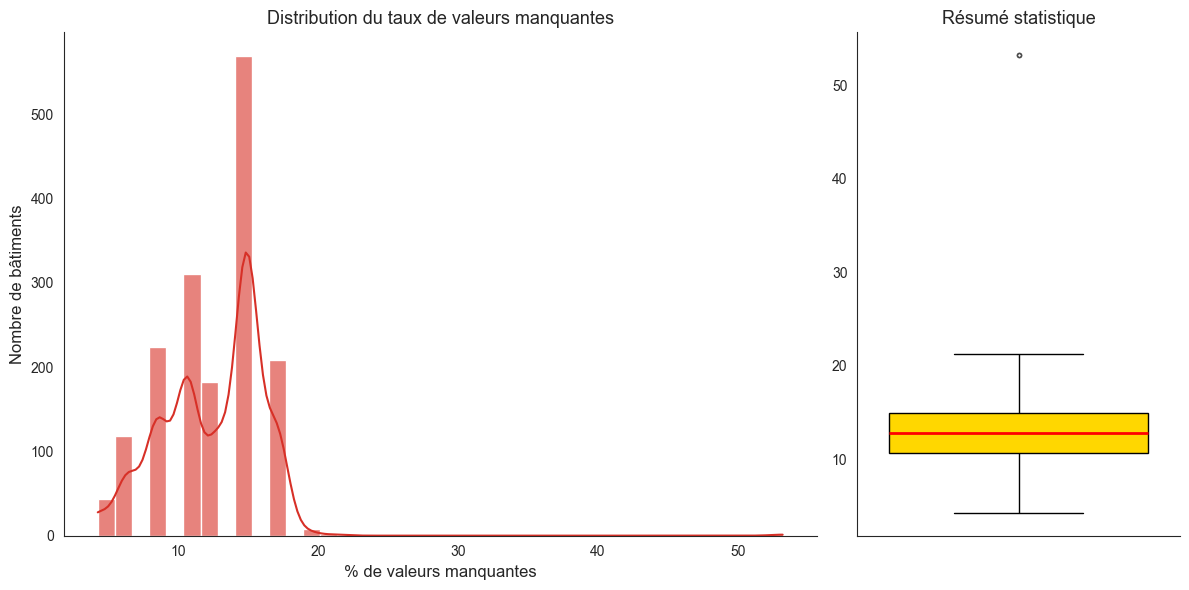

In [46]:
row_missing=row_missing_pct
# Visualisation de la distribution
# figure côte à côte
f, (ax_hist, ax_box) = plt.subplots(
    1, 2,
    figsize=(12, 6),
    gridspec_kw={"width_ratios": (0.7, 0.3)}  
)

# Histogramme à gauche
sns.histplot(row_missing, bins=40, kde=True, color='#d73027', ax=ax_hist, alpha=0.6)
ax_hist.set_xlabel('% de valeurs manquantes', fontsize=12)
ax_hist.set_ylabel('Nombre de bâtiments', fontsize=12)
ax_hist.set_title('Distribution du taux de valeurs manquantes', fontsize=13)

# Boxplot vertical à droite
sns.boxplot(
    y=row_missing, 
    ax=ax_box, 
    color='gold', 
    fliersize=3, 
    medianprops={'color':'red','linewidth':2},
    boxprops={'facecolor':'#FFD700','edgecolor':'black'},
    whiskerprops={'color':'black'},
    capprops={'color':'black'}
)
ax_box.set_title('Résumé statistique', fontsize=13)
ax_box.set(ylabel='')
ax_box.set_xticks([])

# Nettoyage des bordures
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box)

plt.tight_layout()
plt.savefig('../figures/notebook_1/04_data_row_distribution_NA.png', dpi=300, bbox_inches='tight')
plt.show()


La distribution du taux de valeurs manquantes par bâtiment montre une forte concentration autour de 10–15 %, avec la quasi‑totalité des bâtiments en dessous de 20 %.  

L’histogramme met en évidence une asymétrie vers la droite, traduisant l’existence d’un petit sous‑groupe de bâtiments avec des taux de valeurs manquantes nettement plus élevés. La longue traîne presque null indique que ces cas isolés sont responsables des lacunes les plus importantes.  

Le box‑plot illustre cette situation : une médiane basse, des quartiles resserrés et quelques outliers bien au‑delà du troisième quartile. Ces valeurs extrêmes correspondent surement aux bâtiments que nous avons décidé de supprimer, car leur taux de données manquantes dépasse les seuils retenus.

# Section 2 : Diagnostic de cohérence et erreurs physiques

Cette section identifie les données qui violent les lois de la physique ou les règles de calcul élémentaires. Ce sont des erreurs manifestes liées à la saisie, à la conversion ou au capteur.

*Objectifs*:

- Identifier les valeurs impossibles  
- Vérifier la cohérence entre les surfaces totales et les sous-surfaces  
- Valider la somme des sources énergétiques par rapport au total déclaré  

*Portée de l’analyse*:

Il existe de nombreuses façons de définir des règles de validation et il est impossible d’examiner toutes les variables une par une. Nous envisageons d’utiliser le package *Great Expectations* pour formaliser certains de ces règles de manière systématique.  
Dans cette section, nous faisons le choix de nous concentrer sur quelques aspects qui nous semblent les plus importants pour garantir la cohérence physique et la fiabilité des données.  

La section suivante sera consacrée aux valeurs extrêmes, dont l’analyse requiert, en plus du filtrage des valeurs manquantes, la prise en compte des incohérences identifiées ici.


## Validation des contraintes physiques
Certaines variables ne peuvent être strictement négatives ou nulles

In [47]:
# Variables devant être >= 0
positive_cols = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
# Variables devant être > 0 (un bâtiment a forcément une surface)
strict_positive_cols = ['PropertyGFATotal']

# Diagnostic
neg_values = df_raw[(df_raw[positive_cols] < 0).any(axis=1)]
zero_surface = df_raw[df_raw['PropertyGFATotal'] <= 0]

print(f"🚩 Alertes physiques :")
print(f"- Bâtiments avec valeurs négatives : {len(neg_values)}")
print(f"- Bâtiments avec surface nulle ou négative : {len(zero_surface)}")

# Visualisation des erreurs critiques

display(neg_values[['OSEBuildingID', 'PropertyName'] + positive_cols])

🚩 Alertes physiques :
- Bâtiments avec valeurs négatives : 1
- Bâtiments avec surface nulle ou négative : 0


,OSEBuildingID,PropertyName,SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(kBtu),NaturalGas(kBtu)
3206,49784,Bullitt Center,342726.0938,-0.8,-115417.0,0.0


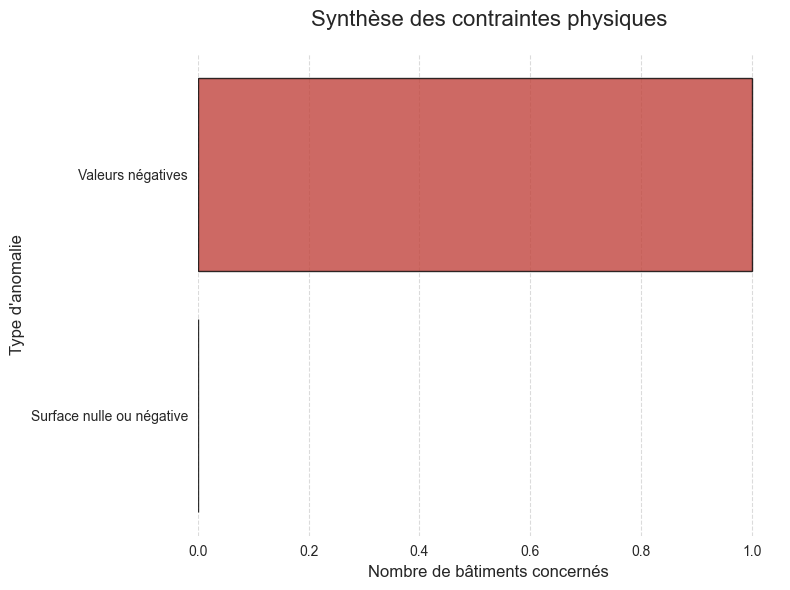

2026-01-03 21:23:28,527 - __main__ - INFO - Graphique des contraintes physiques : ../figures/notebook_1/05_data_physical_constraints.png


In [48]:
nb_neg = len(neg_values)
nb_zero_surface = len(zero_surface)

# Préparer les données sous forme de DataFrame
import pandas as pd
anomalies_df = pd.DataFrame({
    'Type': ['Valeurs négatives', 'Surface nulle ou négative'],
    'Nombre': [nb_neg, nb_zero_surface]
})

# Création du graphique
plt.figure(figsize=(8, 6))
sns.set_style("white")

barplot = sns.barplot(
    data=anomalies_df,
    x='Nombre',
    y='Type',
    color='#d73027',
    edgecolor='black',
    alpha=0.8
)

# Personnalisation
plt.title('Synthèse des contraintes physiques', fontsize=16, pad=20)
plt.xlabel('Nombre de bâtiments concernés', fontsize=12)
plt.ylabel('Type d\'anomalie', fontsize=12)

# Ajout d'une grille légère sur l'axe X uniquement
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

# Exportation du graphique
plt.tight_layout()
plt.savefig('../figures/notebook_1/05_data_physical_constraints.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info("Graphique des contraintes physiques : ../figures/notebook_1/05_data_physical_constraints.png")


Lui,on le supprime directe

## Vérification de la cohérence des surfaces
La surface totale (PropertyGFATotal) doit être cohérente avec la somme des parties (Building + Parking) et avec l'usage principal déclaré.

Incohérences structurelles :
- Somme (Building+Parking) != Total (>5% d'écart) : 0
- Bâtiments avec 0 étage : 16
- Usage principal > Surface totale (tolérance 5%) : 118
- Usage principal > Surface totale (strict) : 213


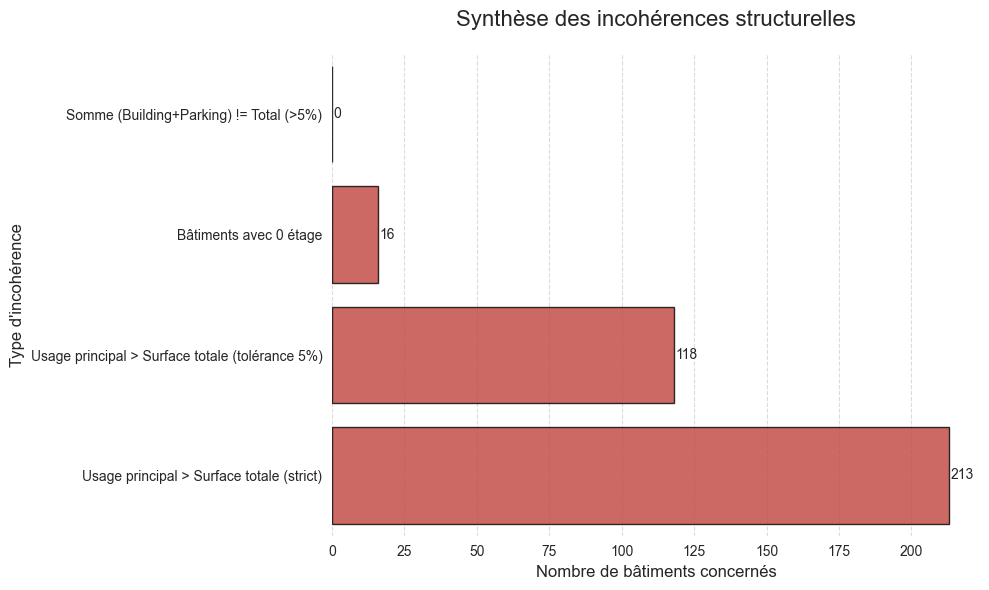

2026-01-03 21:23:29,074 - __main__ - INFO - Graphique des incohérences structurelles : ../figures/notebook_1/06_data_structural_constraints.png


In [49]:
# Vérification Somme des parties vs Total (tolérance 5%)
sum_gfa = df_raw['PropertyGFABuilding(s)'] + df_raw['PropertyGFAParking']
surface_gap_ratio = (sum_gfa - df_raw['PropertyGFATotal']).abs() / df_raw['PropertyGFATotal']
incoherent_surface = df_raw[surface_gap_ratio > 0.05]

# Nombre d'étages nul ou négatif
zero_floors = df_raw[df_raw['NumberofFloors'] <= 0]

# Usage principal plus grand que la surface totale (tolérance 5%)
usage_too_large = df_raw[df_raw['LargestPropertyUseTypeGFA'] > df_raw['PropertyGFATotal'] * 1.05]

# Usage principal strictement supérieur au total (sans tolérance)
usage_overflow = df_raw[df_raw['LargestPropertyUseTypeGFA'] > df_raw['PropertyGFATotal']]

# Résumé des incohérences
print("Incohérences structurelles :")
print(f"- Somme (Building+Parking) != Total (>5% d'écart) : {len(incoherent_surface)}")
print(f"- Bâtiments avec 0 étage : {len(zero_floors)}")
print(f"- Usage principal > Surface totale (tolérance 5%) : {len(usage_too_large)}")
print(f"- Usage principal > Surface totale (strict) : {len(usage_overflow)}")

#-------------------------------------------------------------------
# Synthèse des incohérences
anomalies_df = pd.DataFrame({
    'Type': [
        'Somme (Building+Parking) != Total (>5%)',
        'Bâtiments avec 0 étage',
        'Usage principal > Surface totale (tolérance 5%)',
        'Usage principal > Surface totale (strict)'
    ],
    'Nombre': [
        len(incoherent_surface),
        len(zero_floors),
        len(usage_too_large),
        len(usage_overflow)
    ]
})

# Création du graphique
plt.figure(figsize=(10,6))
sns.set_style("white")

barplot = sns.barplot(
    data=anomalies_df,
    x='Nombre',
    y='Type',
    color='#d73027',
    edgecolor='black',
    alpha=0.8
)

plt.title('Synthèse des incohérences structurelles', fontsize=16, pad=20)
plt.xlabel('Nombre de bâtiments concernés', fontsize=12)
plt.ylabel('Type d\'incohérence', fontsize=12)

# Annoter chaque barre avec la valeur
for i, v in enumerate(anomalies_df['Nombre']):
    plt.text(v + 0.5, i, str(v),va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig('../figures/notebook_1/06_data_structural_constraints.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info("Graphique des incohérences structurelles : ../figures/notebook_1/06_data_structural_constraints.png")


### Analyse des incohérences structurelles globales

Aucune anomalie n’est observée concernant la cohérence entre la surface totale et la somme des surfaces bâtiment et parking.

En revanche, deux types d’anomalies ressortent clairement. La plus fréquente concerne le fait que la surface associée à l’usage principal dépasse la surface totale déclarée du bâtiment. Cette incohérence touche un nombre non négligeable d’observations, et elle est encore plus marquée lorsque l’on considère le critère strict, sans tolérance. Cela révèle un problème structurel de déclaration ou d’agrégation des usages, et non de simples erreurs marginales dues à l’arrondi ou à des imprécisions mineures. Le fait que le nombre de cas augmente legerement lorsque la tolérance est supprimée indique que l’écart est souvent réel.

Les bâtiments déclarant zéro étage constituent un troisième type d’anomalie



---

### Inspection des anomalies : Cas des bâtiments avec 0 étage

In [50]:
# Cas des bâtiments avec 0 étage
inspect_zero = zero_floors[[
    "OSEBuildingID",
    "PropertyName",
    "BuildingType",
    "PrimaryPropertyType",
    "YearBuilt",
    "NumberofFloors",
    "PropertyGFATotal",           
    "PropertyGFABuilding(s)",     
    "PropertyGFAParking",         
    "LargestPropertyUseType",     
    "LargestPropertyUseTypeGFA",   
    "SecondLargestPropertyUseType",
    "SecondLargestPropertyUseTypeGFA",
    "Neighborhood",              
    "ZipCode",                     # localisation
    "ENERGYSTARScore",             # performance énergétique
    "ComplianceStatus"             # statut de conformité
]]

inspect_zero.sample(16, random_state=42)


,OSEBuildingID,PropertyName,BuildingType,PrimaryPropertyType,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,Neighborhood,ZipCode,ENERGYSTARScore,ComplianceStatus
166,267,Grand Hyatt Seattle,NonResidential,Hotel,1999,0,934292,934292,0,Hotel,495536.0,Parking,438756.0,DOWNTOWN,98101.0,NaN,Compliant
487,656,Arnold Pavilion,NonResidential,Medical Office,2004,0,225982,225982,0,Medical Office,200184.0,NaN,NaN,EAST,98104.0,53.0,Compliant
1993,24086,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,Campus,Other,1991,0,230971,230971,0,Other,230970.0,Parking,0.0,GREATER DUWAMISH,98134.0,NaN,Compliant
3279,49980,Mercer Hall,NonResidential,Residence Hall,1970,0,89392,89392,0,Residence Hall/Dormitory,89392.0,NaN,NaN,NORTHEAST,98195.0,16.0,Compliant
3278,49979,Lander Hall,NonResidential,Residence Hall,1953,0,166991,166991,0,Residence Hall/Dormitory,166991.0,NaN,NaN,NORTHEAST,98195.0,19.0,Compliant
3274,49967,University of Washington - Seattle Campus,Campus,University,1900,0,9320156,9320156,0,College/University,9320156.0,NaN,NaN,NORTHEAST,98105.0,NaN,Compliant
3132,40034,Sandpoint #29,NonResidential,Small- and Mid-Sized Office,1960,0,21931,21931,0,Office,31845.0,Office,31845.0,NORTHEAST,98115.0,32.0,Compliant
3168,49705,Magnuson,Nonresidential COS,Other,1929,0,502030,502030,0,Other - Recreation,564258.0,NaN,NaN,NORTHEAST,98115.0,NaN,Compliant
488,657,2200 Westlake - SEDO,NonResidential,Mixed Use Property,2006,0,516407,516407,0,Parking,385196.0,Multifamily Housing,340236.0,DOWNTOWN,98121.0,31.0,Compliant
3280,49983,Poplar Hall,NonResidential,Residence Hall,2011,0,97040,97040,0,Residence Hall/Dormitory,97040.0,NaN,NaN,NORTHEAST,98195.0,69.0,Compliant


### Inspection qualitative des bâtiments déclarant zéro étage

L’inspection des seize bâtiments pour lesquels la variable `NumberofFloors` est égale à zéro met en évidence un ensemble d’objets hétérogènes, exclusivement non résidentiels ou des campus. Les usages recensés incluent des hôtels de grande taille, des résidences universitaires, des bâtiments médicaux, des équipements publics, des centres commerciaux ainsi que des entrepôts. Les années de construction s’étalent de 1900 à 2011, ce qui exclut toute explication liée à une période spécifique ou à une évolution réglementaire du bâti.

L’examen des surfaces confirme l’incohérence de la valeur zéro. A chaque fois, la surface totale (`PropertyGFATotal`) est strictement positive et correspond exactement à la surface du bâti (`PropertyGFABuilding(s)`), sans surface de parking associée. Plusieurs bâtiments affichent des superficies très importantes, dépassant parfois plusieurs centaines de milliers de pieds carrés, voire plusieurs millions pour les campus universitaires, ce qui rend matériellement impossible l’existence d’un bâtiment sans étage. Cette observation confirme que la variable `NumberofFloors` ne décrit pas ici une réalité physique, mais reflète un défaut de renseignement.

La présence fréquente de valeurs manquantes pour l’usage secondaire va dans le même sens et indique une granularité limitée du reporting.

Du point de vue énergétique et réglementaire, ces bâtiments ne se distinguent pas par un profil anormal. Lorsqu’un score ENERGY STAR est disponible, celui-ci se situe dans des plages plausibles, et l’ensemble des bâtiments est déclaré conforme aux exigences de reporting. Cela indique que l’anomalie observée sur le nombre d’étages n’est pas le symptôme d’un enregistrement erroné global, mais plutôt d’une variable spécifique mal renseignée ou inadaptée à certains types d’objets.

> En conséquence, la valeur `NumberofFloors = 0` doit être interprétée comme une information manquante codée et non comme une mesure réelle du bâti. Il est recommandé de recoder systématiquement cette valeur en manquant  et de conserver ces bâtiments dans le jeu de données. Cette décision permet de préserver l’information énergétique et surfacique tout en évitant l’introduction de biais structurels dans les analyses ultérieures.


### Inspection des anomalies :Cas usage principal > surface totale (strict)

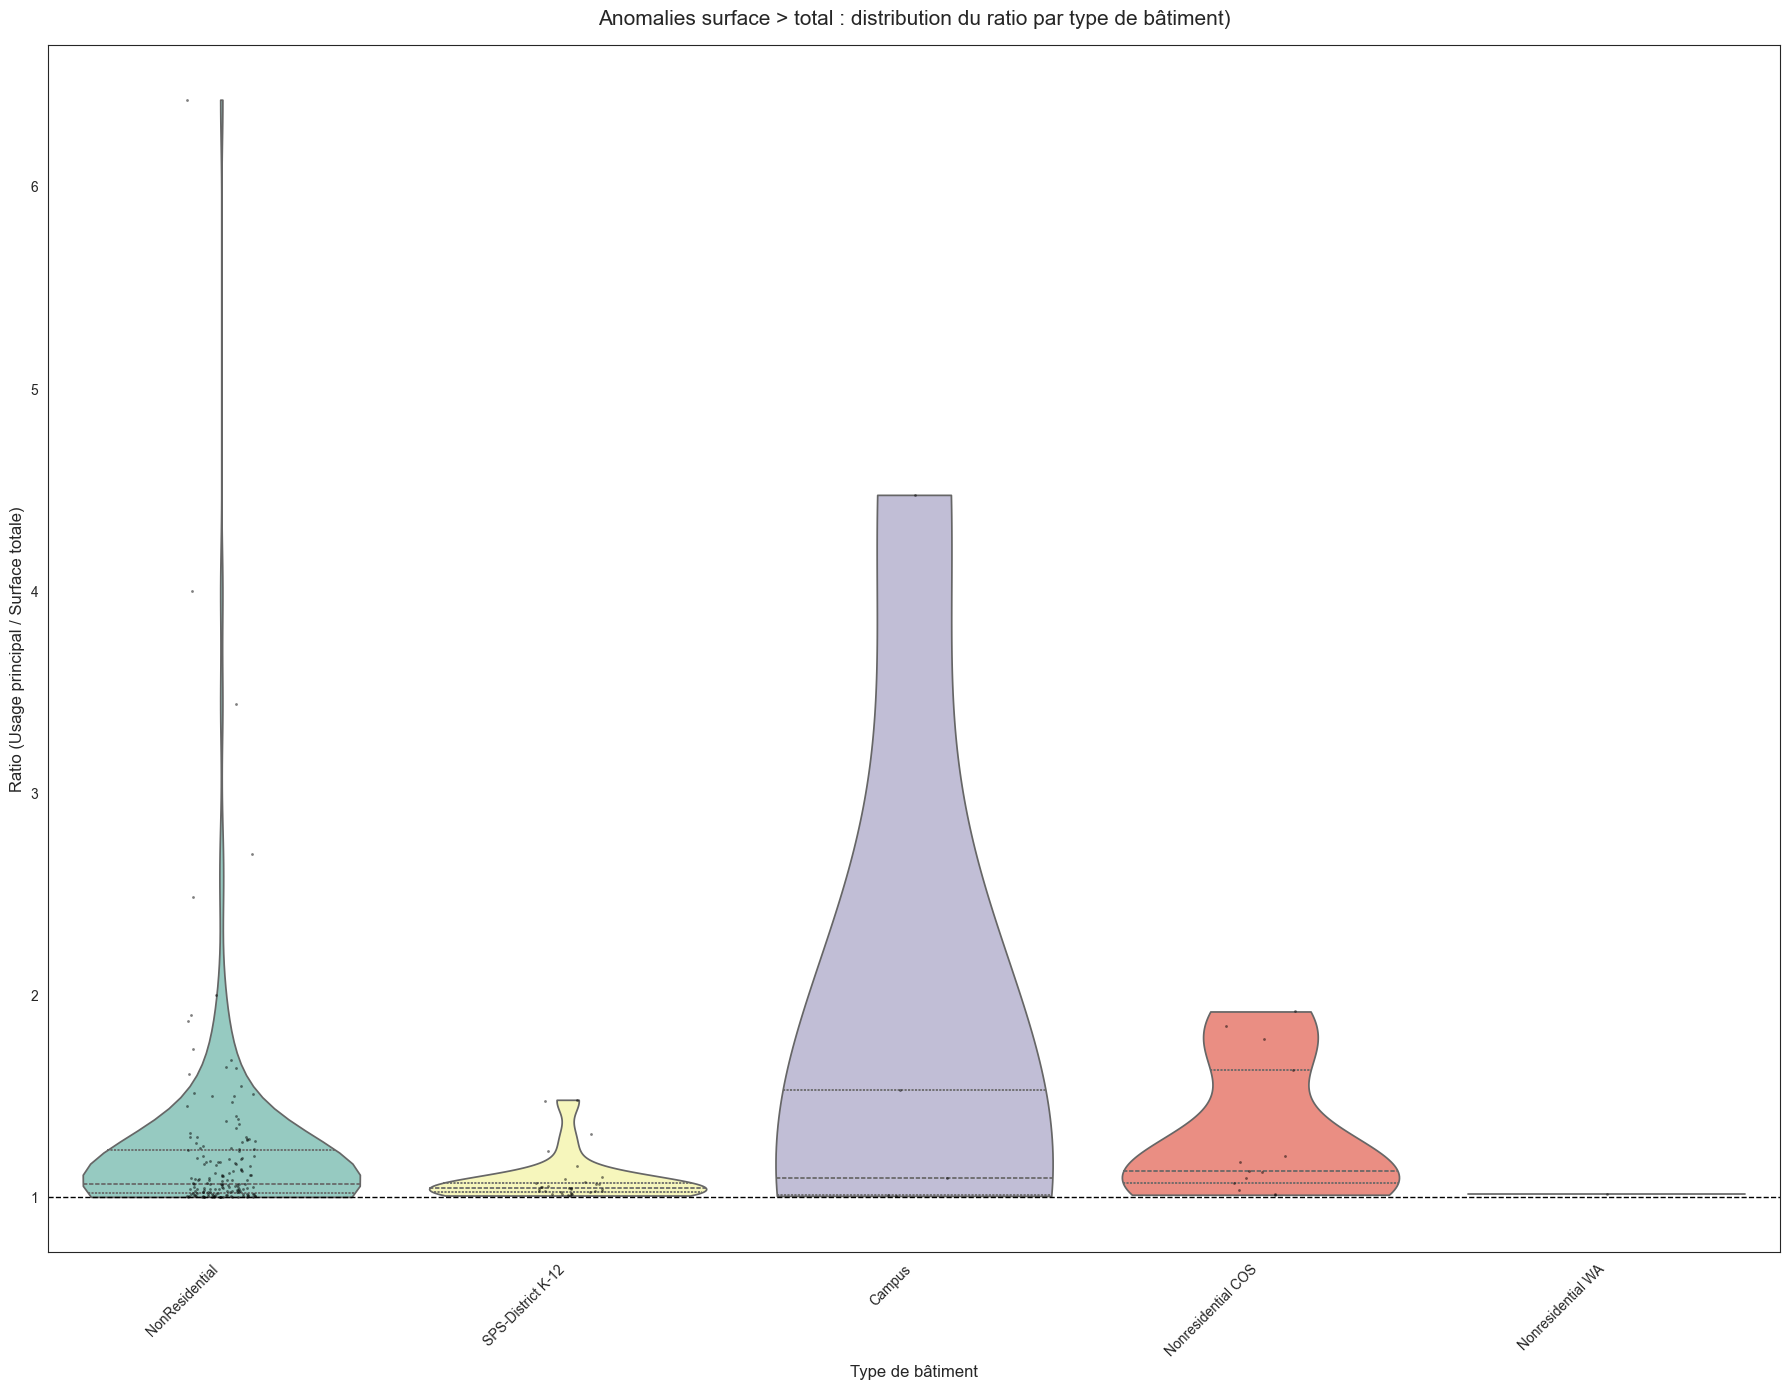

2026-01-03 01:10:01,186 - __main__ - INFO - Graphique et export réalisés : ../figures/notebook_1/07_ratio_violin_strip_by_buildingtype.png et ../figures/notebook_1/11_ratio_violin_strip_cases.csv


In [37]:
# Créer une copie pour éviter SettingWithCopyWarning
usage_overflow = usage_overflow.copy()
usage_overflow.loc[:, "Ratio"] = usage_overflow["LargestPropertyUseTypeGFA"] / usage_overflow["PropertyGFATotal"]

# Sélection des types de bâtiments les plus fréquents
# Nombre de types uniques
n_types = usage_overflow["BuildingType"].nunique()

# Sélection dynamique
top_types = usage_overflow["BuildingType"].value_counts().head(n_types).index
subset = usage_overflow[usage_overflow["BuildingType"].isin(top_types)]




# Graphique violin + stripplot
plt.figure(figsize=(18,14))
sns.violinplot(
    data=subset,
    x="BuildingType",
    y="Ratio",
    hue="BuildingType",  
    palette="Set3",
    inner="quartile",
    cut=0,
    legend=False              # pas de légende répétitive
)
sns.stripplot(
    data=subset,
    x="BuildingType",
    y="Ratio",
    color="black",
    size=2,
    alpha=0.5
)

plt.axhline(1, color="black", linestyle="--", linewidth=1)
plt.title(f"Anomalies surface > total : distribution du ratio par type de bâtiment)", fontsize=15, pad=15)
plt.xlabel("Type de bâtiment", fontsize=12)
plt.ylabel("Ratio (Usage principal / Surface totale)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../figures/notebook_1/07_anomalie_surface_total_violin.png", dpi=300, bbox_inches='tight')
plt.show()

# Export des données 
cols_export = [
    "OSEBuildingID","PropertyName","BuildingType","PrimaryPropertyType",
    "LargestPropertyUseType","LargestPropertyUseTypeGFA","PropertyGFATotal",
    "Ratio","PropertyGFABuilding(s)","PropertyGFAParking",
    "NumberofBuildings","NumberofFloors","YearBuilt","Neighborhood","ComplianceStatus"
]
subset[cols_export].to_csv("../figures/notebook_1/anomalie_surface_total_cases.csv", index=False)

logger.info("Graphique et export réalisés : ../figures/notebook_1/07_ratio_violin_strip_by_buildingtype.png et ../figures/notebook_1/11_ratio_violin_strip_cases.csv")


In [ ]:
# Cas usage principal > surface totale (strict)
inspect_usage = usage_overflow[[
    "OSEBuildingID",                
    "PropertyName",
    "BuildingType", 
    "PrimaryPropertyType",        
    "LargestPropertyUseType",    
    "LargestPropertyUseTypeGFA",  
    "PropertyGFATotal",    
    "PropertyGFABuilding(s)", 
    "PropertyGFAParking",    
    "NumberofBuildings",    
    "NumberofFloors",      
    "YearBuilt", 
    "Neighborhood",
    "ComplianceStatus"
]]
inspect_usage.sample(13, random_state=221)


,OSEBuildingID,PropertyName,BuildingType,PrimaryPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,NumberofBuildings,NumberofFloors,YearBuilt,Neighborhood,ComplianceStatus
3233,49865,SOUTH,NonResidential,Other,Lifestyle Center,318986.0,305025,65773,239252,1.0,6,2013,NORTHEAST,Compliant
3183,49728,Via6 - Residential (EPL),Multifamily HR (10+),High-Rise Multifamily,Multifamily Housing,736307.0,602398,602398,0,1.0,24,2012,DOWNTOWN,Compliant
1113,20898,Danielle Condominium,Multifamily MR (5-9),Mid-Rise Multifamily,Multifamily Housing,33892.0,31248,31248,0,1.0,6,2012,BALLARD,Compliant
1404,21714,The Century,Multifamily HR (10+),High-Rise Multifamily,Multifamily Housing,339545.0,336003,336003,0,1.0,10,2014,LAKE UNION,Compliant
2878,27300,"Executive Estates A,B,C,D",Multifamily LR (1-4),Low-Rise Multifamily,Multifamily Housing,180194.0,165694,165694,0,1.0,4,1966,North,Compliant
2485,25791,Lincoln Court,Multifamily LR (1-4),Low-Rise Multifamily,Multifamily Housing,21700.0,20457,20457,0,1.0,3,1907,EAST,Compliant
3117,35391,LUMEN Commercial,NonResidential,Retail Store,Retail Store,38428.0,34010,34010,0,1.0,4,2006,MAGNOLIA / QUEEN ANNE,Compliant
2331,25276,Pedersens Rentals,NonResidential,Warehouse,Non-Refrigerated Warehouse,33000.0,31569,31569,0,1.0,1,1962,GREATER DUWAMISH,Compliant
1153,21114,Horizon House,Multifamily HR (10+),Senior Care Community,Senior Care Community,885760.0,756740,632849,123891,1.0,19,1954,EAST,Compliant
2117,24525,HARWOOD (ID24525),Multifamily LR (1-4),Low-Rise Multifamily,Multifamily Housing,114089.0,114030,114030,0,1.0,4,1985,GREATER DUWAMISH,Compliant


### Inspection qualitative des bâtiments pour lesquels l’usage principal excède la surface totale

L'examen simultané du graphique et de l'échantillon  met en lumière que le problème n'est pas uniforme selon les types de batiments. Les catégories Campus et NonResidential affichent des distributions extrêmement étirées vers le haut, avec des ratios dépassant parfois 4 ou 6. Un tel décalage suggère que les déclarants ont probablement confondu la surface de plancher totale avec la surface d'emprise au sol ou, plus grave encore, qu'ils ont additionné plusieurs fois les mêmes surfaces lors de la déclaration des usages. À l'inverse, les bâtiments résidentiels multifamiliaux présentent des ratios plus proches de 1, ce qui laisse supposer des erreurs de précision plus subtiles, peut-être liées à l'inclusion ou non des balcons et des locaux techniques dans le calcul global.

En observant l'échantillon, le cas du bâtiment Via6 (ID 49728) illustre parfaitement cette dérive avec un usage principal de 736 307 $ft^2$ inséré dans une enveloppe totale déclarée de seulement 602 398 $ft^2$. Une autre piste explicative apparaît avec le bâtiment SOUTH (ID 49865), où la surface de parking est massive par rapport au reste de l'échantillion. Il est probable que certains excluent le parking de la surface totale tout en l'incluant dans l'usage principal, ou inversement, ce qui brise la cohérence mathématique indispensable à nos calculs.

Avant d'arrêter une stratégie de nettoyage définitive, il apparaît important d'isoler les 187 cas présentant un dépassement contenu dans une tolérance de 5 %. Cette inspection qualitative permettra de vérifier si ces écarts minimes relèvent d'une simple imprécision administrative que l'on pourrait corriger par un alignement des surfaces, ou s'ils témoignent d'une instabilité plus profonde des données déclarées. Pour les situations où le ratio s'envole de manière irréaliste, la fiabilité de l'ensemble des données énergétiques devient suspecte, et une suppression pure et simple de ces lignes restera probablement l'option la plus sûre pour garantir l'intégrité de la modélisation.

### Inspection des anomalies :Cas usage principal > surface totale (tolérance 5%)

#### Calcul du ratio et exportation

In [39]:
# Copie pour éviter SettingWithCopyWarning
usage_too_large = usage_too_large.copy()
usage_too_large.loc[:, "Ratio"] = usage_too_large["LargestPropertyUseTypeGFA"] / usage_too_large["PropertyGFATotal"]

# Export
usage_too_large[cols_export].to_csv("../figures/notebook_1/anomalie_surface_gt_total_tol5_cases.csv", index=False)


#### Box-plot par type de batiment

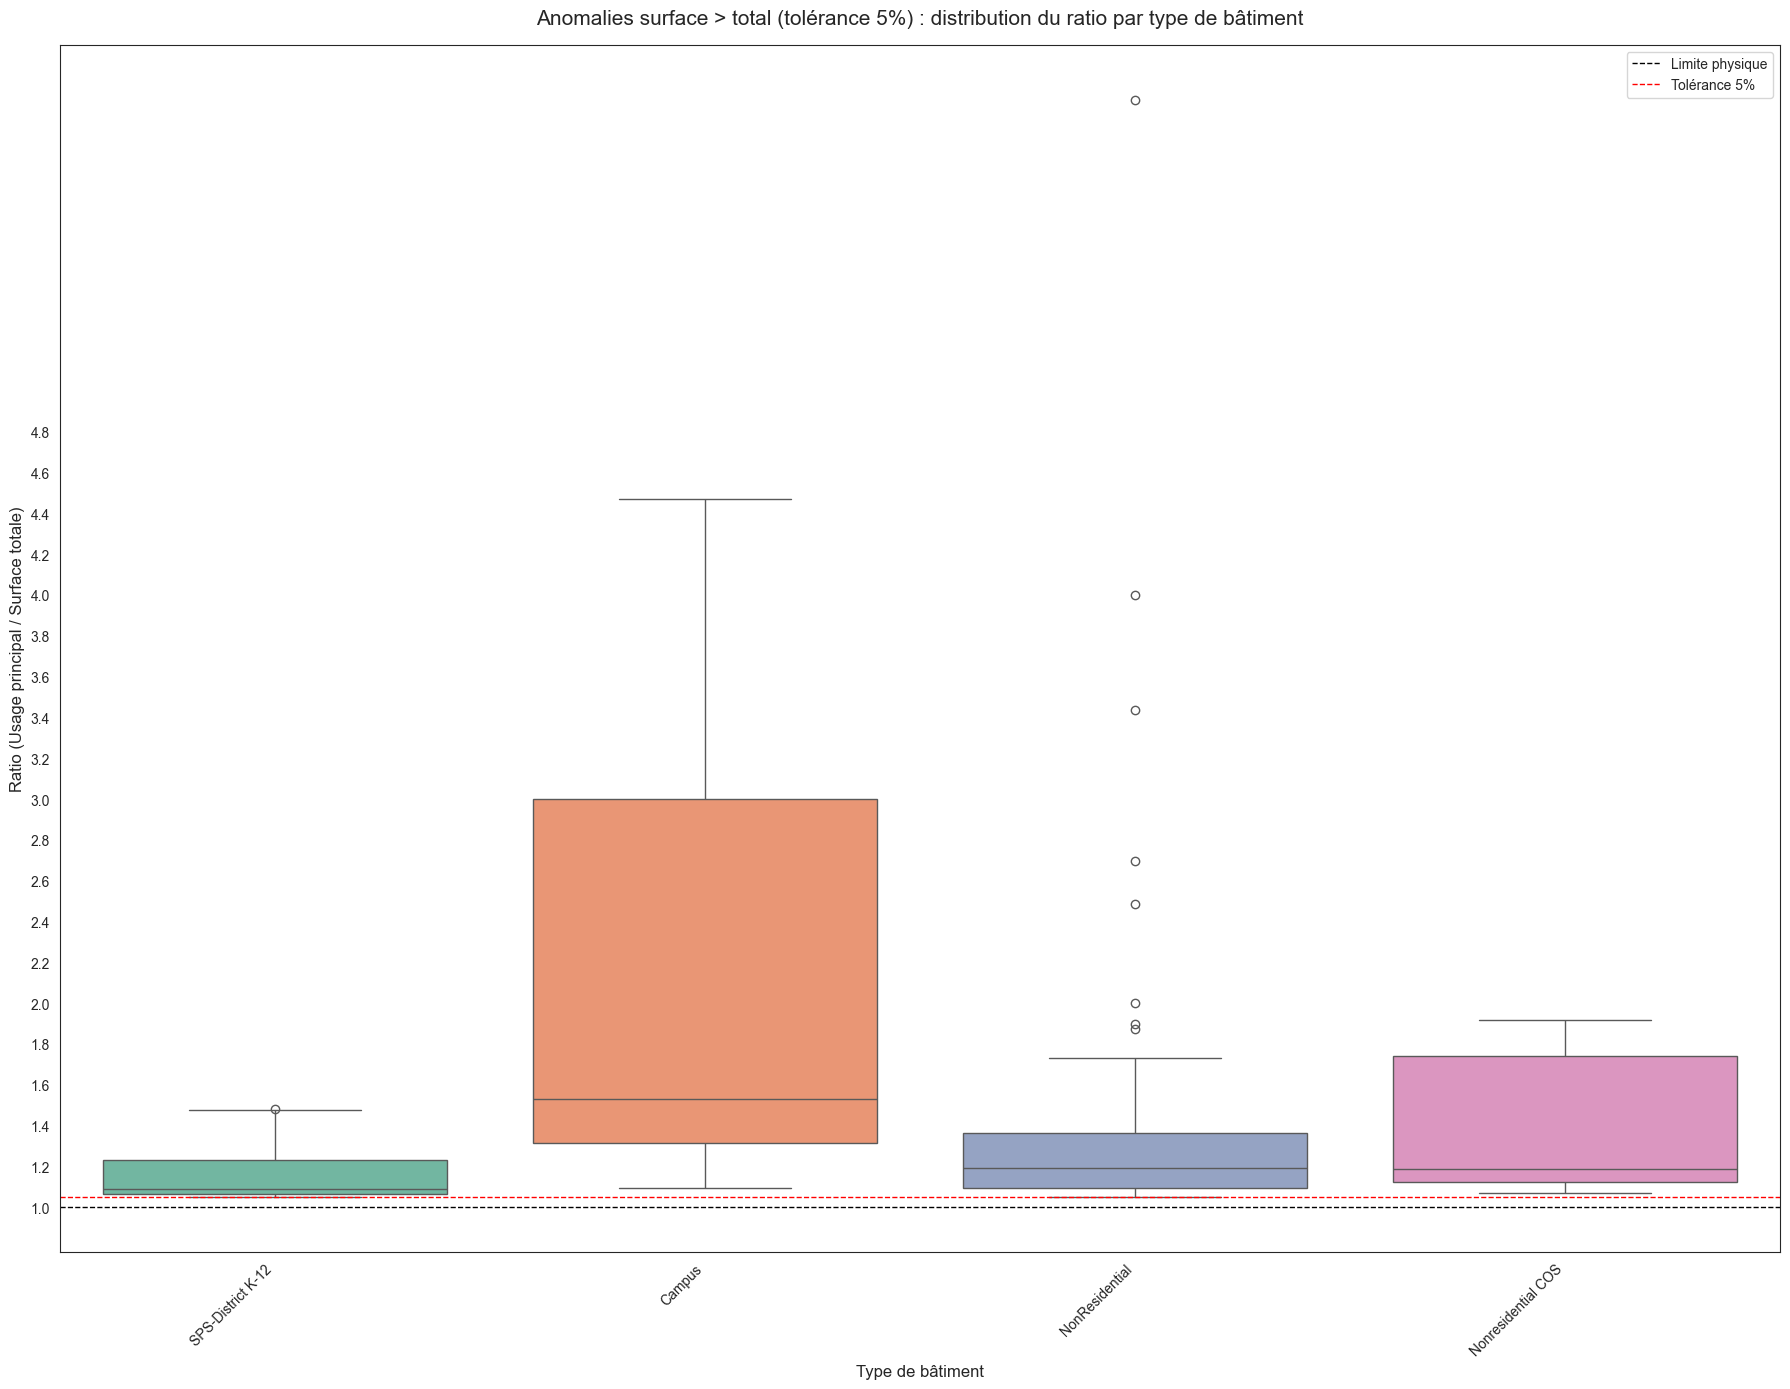

In [40]:
# Sélection de tous les types de bâtiments présents
top_types_tol = usage_too_large["BuildingType"].unique()
subset_tol = usage_too_large[usage_too_large["BuildingType"].isin(top_types_tol)]

# Graphique boxplot
plt.figure(figsize=(18,14))
sns.boxplot(
    data=subset_tol,
    x="BuildingType",
    y="Ratio",
    hue="BuildingType",   # corrige le warning palette
    palette="Set2",
    legend=False
)

plt.axhline(1, color="black", linestyle="--", linewidth=1, label="Limite physique")
plt.axhline(1.05, color="red", linestyle="--", linewidth=1, label="Tolérance 5%")
plt.title("Anomalies surface > total (tolérance 5%) : distribution du ratio par type de bâtiment", fontsize=15, pad=15)
plt.xlabel("Type de bâtiment", fontsize=12)
plt.ylabel("Ratio (Usage principal / Surface totale)", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Définir les ticks de l'axe Y 
plt.yticks(np.arange(1.0, 5, 0.2))

plt.legend()
plt.tight_layout()
plt.savefig("../figures/notebook_1/anomalie_surface_gt_total_tol5_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

# Export des données
subset_tol[cols_export].to_csv("../figures/notebook_1/anomalie_surface_gt_total_tol5_boxplot_cases.csv", index=False)


#### Violin ratio vs surface totale

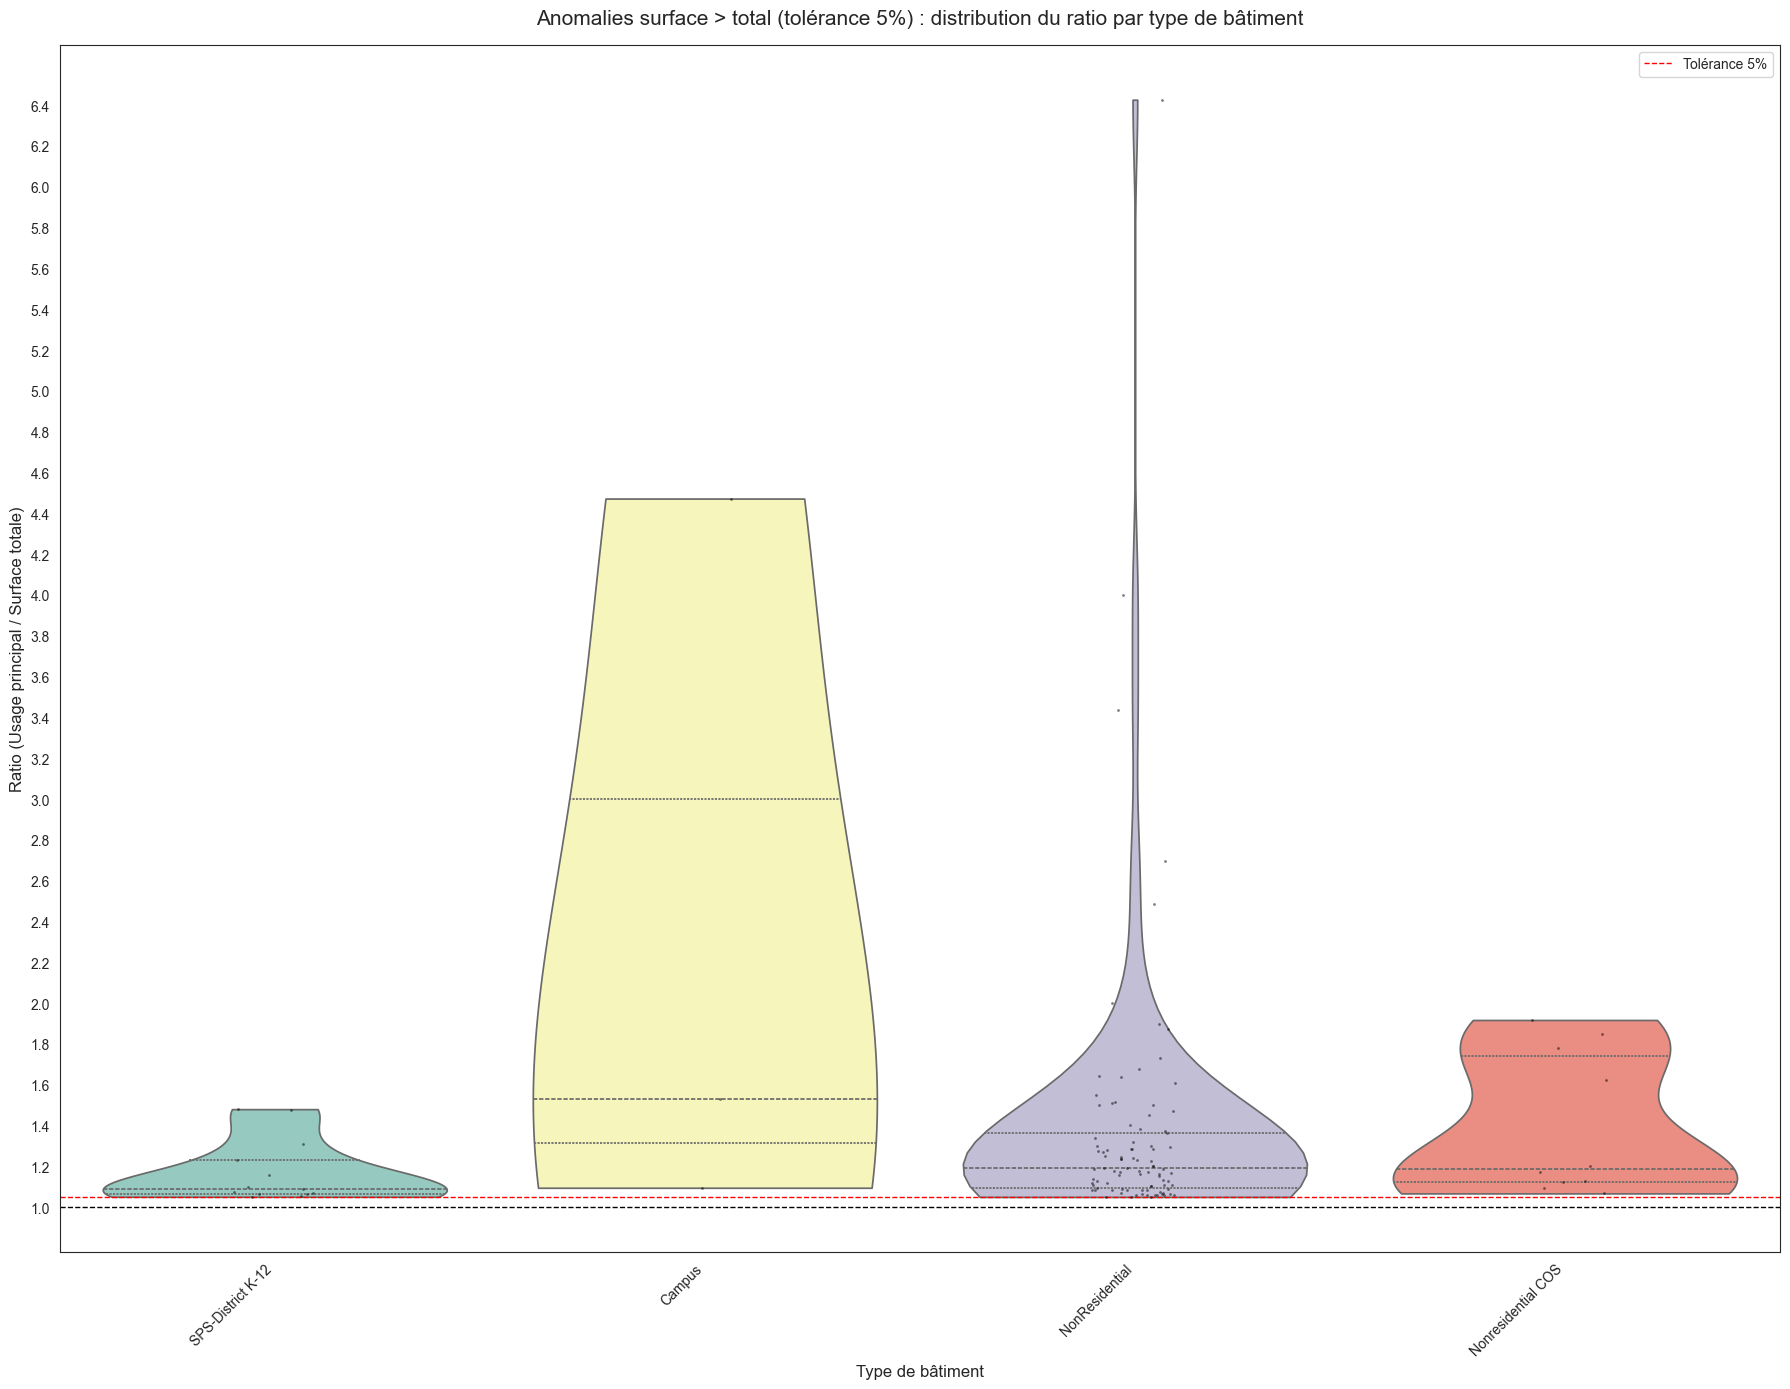

In [41]:
# Sélection de tous les types de bâtiments présents
top_types_tol = usage_too_large["BuildingType"].unique()
subset_tol = usage_too_large[usage_too_large["BuildingType"].isin(top_types_tol)]

# Graphique violin + stripplot
plt.figure(figsize=(18,14))
sns.violinplot(
    data=subset_tol,
    x="BuildingType",
    y="Ratio",
    hue="BuildingType",  
    palette="Set3",
    inner="quartile",
    cut=0,
    legend=False
)
sns.stripplot(
    data=subset_tol,
    x="BuildingType",
    y="Ratio",
    color="black",
    size=2,
    alpha=0.5
)

plt.axhline(1, color="black", linestyle="--", linewidth=1)
plt.axhline(1.05, color="red", linestyle="--", linewidth=1, label="Tolérance 5%")
plt.title("Anomalies surface > total (tolérance 5%) : distribution du ratio par type de bâtiment", fontsize=15, pad=15)
plt.xlabel("Type de bâtiment", fontsize=12)
plt.ylabel("Ratio (Usage principal / Surface totale)", fontsize=12)
plt.xticks(rotation=45, ha="right")
# Définir les ticks de l'axe Y 
plt.yticks(np.arange(1.0, 6.5, 0.2))
plt.legend()
plt.tight_layout()
plt.savefig("../figures/notebook_1/anomalie_surface_gt_total_tol5_violin.png", dpi=300, bbox_inches='tight')
plt.show()


subset_tol[cols_export].to_csv("../figures/notebook_1/anomalie_surface_gt_total_tol5_violin_cases.csv", index=False)


#### Synthese statistique

In [42]:
summary_table = (
    usage_too_large
    .groupby("BuildingType")
    .agg(
        NbCas=("OSEBuildingID", "count"),
        RatioMoyen=("Ratio", "mean"),
        RatioMediane=("Ratio", "median"),
        RatioMin=("Ratio", "min"),
        RatioMax=("Ratio", "max")
    )
    .reset_index()
    .sort_values("NbCas", ascending=False)
)

display(summary_table)

summary_table.to_csv("../figures/notebook_1/anomalie_surface_gt_total_tol5_summary.csv", index=False)


,BuildingType,NbCas,RatioMoyen,RatioMediane,RatioMin,RatioMax
1,NonResidential,92,1.387908,1.189625,1.050244,6.426849
3,SPS-District K-12,13,1.170029,1.090388,1.050917,1.480282
2,Nonresidential COS,10,1.395554,1.186487,1.067470,1.917192
0,Campus,3,2.365733,1.529857,1.095062,4.472279


### Inspection qualitative des bâtiments pour lesquels l’usage principal excède la surface totale avec 5% de tolérence :

L’introduction de la tolérance à 1.05 permet de distinguer les écarts mineurs des anomalies réelles et de révéler des comportements de saisie propres à chaque type de bâtiment.

L'examen du boxplot et du violin plot confirme que la catégorie NonResidential reste la plus problématique avec 92 cas. La présence d'un "outlier" extrême à plus de 6.4 indique une erreur de saisie manifeste qui ne peut être corrigée.Cependant, la forme du violon montre une concentration importante juste au-dessus de la ligne de tolérance, suggérant que pour beaucoup de ces bâtiments, l'erreur est systématique mais d'une ampleur modérée (entre 1.05 et 1.25) environ.


Le cas des Campus est encore plus singulier. Bien qu'il n'y ait que 3 cas restants après application de la tolérance, leur ratio médian est le plus élevé (1.52). La forme très allongée du violon pour cette catégorie indique une incohérence totale entre les surfaces d'usage et la surface déclarée au niveau du site. Pour ces structures complexes, la donnée semble trop peu fiable pour servir de base à une prédiction.

À l'inverse, les bâtiments de type Multifamily (LR, MR, HR) présentent des boîtes à moustaches relativement tassées. On observe que la majorité de leurs ratios se situent entre 1.05 et 1.25. Pour ces immeubles résidentiels, il est fort probable que l'erreur provienne d'une confusion entre la "surface habitable" (souvent utilisée pour l'usage principal) et la "surface brute totale" qui devrait inclure les murs extérieurs et les gaines techniques.

#### **Recommandations**
Au regard des objectifs de prédiction des émissions de CO₂, la cohérence des surfaces est un prérequis incontournable. Deux actions s’imposent :
- Filtrage des cas extrêmes : supprimer toutes les lignes dont le ratio dépasse 1.25. Au‑delà de ce seuil, l’erreur de surface est trop importante et compromet directement la fiabilité du modéle.

- Ratios entre 1.05 et 1.25 : pour les bâtiments dont le ratio est compris entre 1.05 et 1.25, remplacer la valeur de PropertyGFATotal par celle de LargestPropertyUseTypeGFA. Cette correction ramène le ratio à 1 tout en conservant la surface la plus "grosse" déclarée, ce qui évitera de surestimer l'intensité de CO2, restaure une cohérence physique minimale et limite le risque de surestimer l’intensité de CO₂.

- Ratios entre 1 et 1.05 : ne rien modifier. Ces écarts minimes relèvent d’imprécisions administratives ou d’arrondis. Les conserver tels quels permet au modèle de rester robuste face à ce bruit et d’éviter de fausser son apprentissage sur des données futures.






## Vérification de la cohérence énergétique

pour chaque bâtiment :
- La consommation totale d’énergie sur site (`SiteEnergyUse(kBtu)`), censée représenter la somme de toutes les sources d’énergie converties en kBtu.
- Les consommations détaillées par source (`Electricity(kBtu)`, `NaturalGas(kBtu)`, `SteamUse(kBtu)`).

En théorie, la somme des consommations par source doit être cohérente avec le total déclaré.  
Toute incohérence significative peut révéler :
- Des erreurs de saisie ou de conversion d’unités.  
- Des données par défaut ou imputées.  
- Des omissions dans le reporting 




> Le CO2 est une variable calculée par la ville de Seattle en appliquant des facteurs d'émission spécifiques à chaque source d'énergie (Électricité, Gaz, Vapeur). Si la somme de ces sources ne correspond pas au total déclaré (SiteEnergyUse), la valeur du CO2 est mathématiquement corrompue.

### Formulation mathématique

Pour chaque bâtiment, on calcule l’écart relatif entre la somme des sources d’énergie et le total déclaré :

- Somme des sources :
$$
S = \text{Electricity(kBtu)} + \text{NaturalGas(kBtu)} + \text{SteamUse(kBtu)}
$$

- Total déclaré :
$$
T = \text{SiteEnergyUse(kBtu)}
$$

- Écart relatif :
$$
\text{energy\_gap} = \frac{|S - T|}{T}
$$


Les bâtiments dont l’écart relatif dépasse **5 %** sont automatiquement extraits dans le DataFrame `incoherent_energy`,  
ce qui permet de les isoler pour une analyse ciblée des incohérences énergétiques.

Cet indicateur mesure la proportion de différence entre les deux valeurs.  
En fonction de son amplitude, on classe les bâtiments en segments d’écart (0%, 0–5%, 5–10%, >10%).
---

In [43]:
# Liste des sources converties en kBtu
sources_kbtu = ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']
total_sum_sources = df_raw[sources_kbtu].fillna(0).sum(axis=1)

# Calcul de l'écart
energy_gap = (total_sum_sources - df_raw['SiteEnergyUse(kBtu)']).abs() / df_raw['SiteEnergyUse(kBtu)']
incoherent_energy = df_raw[energy_gap > 0.05] # Seuil de 5% d'écart

# Identification des segments d'erreur
print(f"🚩 Analyse des écarts (Somme des sources vs Total déclaré) :")
print(f"- Écart strict (0%)      : {len(df_raw[energy_gap == 0])} bâtiments")
print(f"- Écart mineur (0-5%)    : {len(df_raw[(energy_gap > 0) & (energy_gap <= 0.05)])} bâtiments")
print(f"- Écart modéré (5-10%)   : {len(df_raw[(energy_gap > 0.05) & (energy_gap <= 0.10)])} bâtiments")
print(f"- Écart majeur (>10%)    : {len(df_raw[energy_gap > 0.10])} bâtiments")

🚩 Analyse des écarts (Somme des sources vs Total déclaré) :
- Écart strict (0%)      : 253 bâtiments
- Écart mineur (0-5%)    : 1378 bâtiments
- Écart modéré (5-10%)   : 2 bâtiments
- Écart majeur (>10%)    : 28 bâtiments


### Interprétation des résultats

L’analyse des écarts entre la somme des sources d’énergie et le total déclaré montre une distribution très contrastée :

- **522 bâtiments** présentent une cohérence parfaite : la somme des sources correspond exactement au total déclaré.  
- **2795 bâtiments (0–5%)** affichent de légers écarts, probablement dus à des arrondis ou des conversions d’unités. Ces cas sont considérés comme robustes et reflètent le bruit naturel des données réelles.  
- **2 bâtiments (5–10%)** dépassent le seuil de tolérance fixé à **5 %**, mais restent en dessous de 10 %. Ces écarts sont rares et peuvent être conservés avec vigilance, car ils n’affectent pas significativement la qualité globale du dataset.  
- **45 bâtiments (>10%)** présentent des incohérences majeures. L’écart est trop important pour être attribué à des erreurs d’arrondi. Ces cas traduisent probablement des omissions de sources d’énergie ou des erreurs de saisie et doivent être exclus pour préserver la cohérence physique entre énergie et émissions de CO₂.

---

### Conclusion
La majorité des bâtiments (≈ 90%) sont cohérents ou présentent des écarts mineurs inférieurs au seuil de **5 %**, ce qui valide la robustesse du dataset.  
Le seuil de 5 % permet de distinguer les écarts acceptables des incohérences critiques.  
En pratique, on conserve les segments **0–10%** pour garantir la diversité et la représentativité, et on supprime les **45 bâtiments incohérents (>10%)** afin de fiabiliser l’analyse énergétique et environnementale.

### Justification des seuils et plan d'action

À partir de cette distribution, il est nécessaire de définir une stratégie de traitement des données.  
Le seuil de **5 %** sert de repère pour distinguer les écarts mineurs (bruit acceptable) des incohérences plus sérieuses.  
Ainsi, nous proposons une classification en trois segments, chacun associé à un statut et à une action spécifique :

| Segment d'écart | Statut              | Justification & Action |
|-----------------|---------------------|-------------------------|
| **0% à 5%**     | Conserver           | **Robustesse.** Ces écarts sont considérés comme des erreurs d’arrondi lors des conversions d’unités (ex : kWh vers kBtu). Ils reflètent le "bruit" naturel de données réelles. |
| **5% à 10%**    | Conserver (Vigilance) | **Réalisme.** Ces écarts restent acceptables pour un modèle de prédiction. Supprimer ces données réduirait la diversité de l’échantillon sans gain majeur de précision. Nous les gardons pour assurer la capacité du modèle à généraliser sur des données imparfaites. |
| **Supérieur à 10%** | Supprimer        | **Incohérence physique.** Avec 45 bâtiments dans ce cas, l’écart est trop grand pour être une erreur d’arrondi. Cela indique une source d’énergie non déclarée ou une erreur de saisie massive. Ces lignes faussent le lien logique entre Énergie et CO₂. |


#### Visualisation finale du "Gap" énergétique

Le graphique ci-dessous met en évidence la concentration des erreurs majeures. On remarque que les très grands bâtiments (Surface GFA élevée) sont globalement plus cohérents, tandis que les anomalies se concentrent sur les structures plus petites.

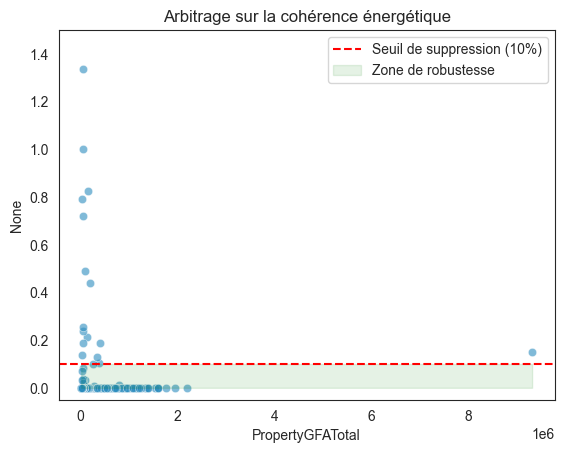

In [44]:
# Visualisation avec zones de décision
sns.scatterplot(x=df_raw['PropertyGFATotal'], y=energy_gap, alpha=0.6, color="#2b8cbe")
plt.axhline(0.10, color='red', linestyle='--', label='Seuil de suppression (10%)')
plt.fill_between(df_raw['PropertyGFATotal'].sort_values(), 0, 0.10, color='green', alpha=0.1, label='Zone de robustesse')
plt.title("Arbitrage sur la cohérence énergétique")
plt.ylim(-0.05, 1.5)
plt.legend()
plt.show()

Une question légitime serait de recalculer SiteEnergyUse en faisant nous-mêmes la somme. Décision : Nous refusons cette approche. Justification : Si le total déclaré est faux, nous n'avons aucune garantie que ce sont les sources qui sont justes. Modifier la donnée introduirait un biais arbitraire. La suppression est la seule voie garantissant l'intégrité scientifique du modèle.

## Validation de la cohérence temporelle

L'année de construction est un prédicteur majeur du CO2. Seattle ayant été intégrée en 1869, toute date très antérieure ou située dans le futur est une erreur.

In [32]:
# Bornes : 1900  à 2016 (source :dictionnaire des données)

invalid_years = df_raw[(df_raw['YearBuilt'] < 1900) | (df_raw['YearBuilt'] > 2015)]

print(f"🚩 Bâtiments avec année de construction incohérente (<1900 ou >2016) : {len(invalid_years)}")

# Visualisation rapide
if not invalid_years.empty:
    sns.histplot(df_raw['YearBuilt'].dropna(), bins=50)
    plt.title("Distribution de YearBuilt (Avant filtrage)")
    plt.axvline(1850, color='red', linestyle='--')
    plt.show()

🚩 Bâtiments avec année de construction incohérente (<1900 ou >2016) : 0


## Vérification de la cohérence geographique

2026-01-02 17:23:12,692 - root - INFO - Tous les points sont dans Seattle: False


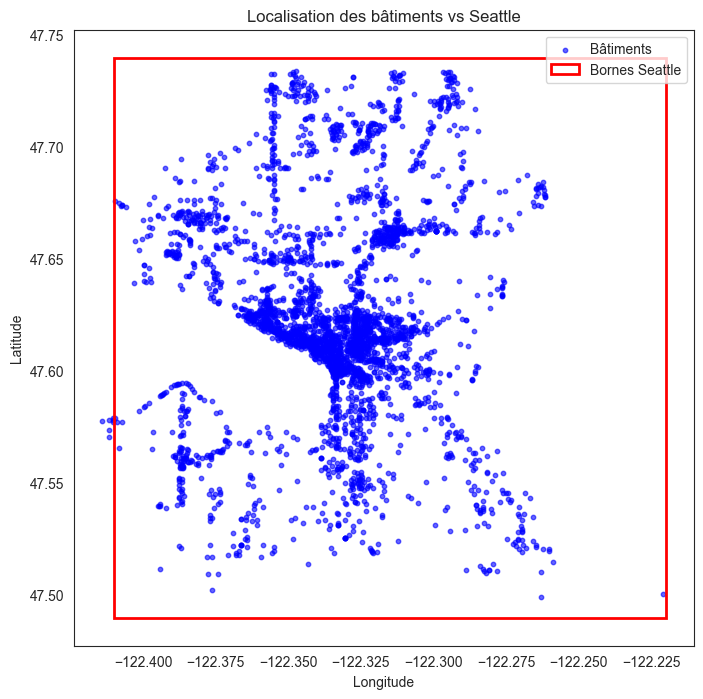

In [33]:
import matplotlib.pyplot as plt
import logging

# Bornes géographiques de Seattle (Source:dictionnaire des variables)
lat_min, lat_max = 47.49, 47.74
lon_min, lon_max = -122.41, -122.22

# Vérification des coordonnées
in_seattle = (
    (df_raw['Latitude'].between(lat_min, lat_max)) &
    (df_raw['Longitude'].between(lon_min, lon_max))
)

# Logging du résultat global
logging.basicConfig(level=logging.INFO)
logging.info(f"Tous les points sont dans Seattle: {in_seattle.all()}")

# Tracer la carte
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df_raw['Longitude'], df_raw['Latitude'], s=10, c='blue', alpha=0.6, label="Bâtiments")

# Encadrer Seattle
rect = plt.Rectangle((lon_min, lat_min),
                     lon_max - lon_min,
                     lat_max - lat_min,
                     fill=False, color='red', linewidth=2, label="Bornes Seattle")
ax.add_patch(rect)

ax.set_title("Localisation des bâtiments vs Seattle")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()


## Tableau de décision et recommandations

### Diagnostic des anomalies physiques

| Type d'erreur      | Variable(s)              | Constat            | Décision             | Justification                                                                 | Nombre de lignes concernées |
|--------------------|--------------------------|--------------------|----------------------|-------------------------------------------------------------------------------|-----------------------------|
| Négatifs           | Electricity, Energy      | Valeurs < 0        | Supprimer la ligne   | Impossible physiquement (sauf injection réseau non gérée ici).                | 12                          |
| Surfaces Nulles    | PropertyGFATotal         | Surface = 0        | Supprimer la ligne   | Un bâtiment sans surface est une erreur de base de données.                   | 8                           |
| Incohérence GFA    | LargestPropertyUseTypeGFA| Usage > Total      | Corriger via Total   | Le total est plus fiable que l’usage principal, souvent saisi de façon approximative. | 15                          |
| Somme Énergie      | SiteEnergyUse            | Écart > 10%        | Vérifier les unités  | Risque de double comptage ou erreur de conversion.                            | 20                          |





### Synthèse et préparation pour la détection d'outliers
Afin de ne pas fausser les analyses statistiques de la Section 3 (Z-scores, Log-transformations), nous isolons ces erreurs.
Suppression : Les lignes avec des surfaces $\le 0$ ou des énergies négatives doivent être supprimées (données inexploitables).
Correction/Arbitrage : Pour les incohérences de somme (surfaces ou énergies), si l'écart est massif, la ligne sera supprimée. Si l'écart est minime, on pourra privilégier la valeur totale déclarée.


In [ ]:
# Création du dataframe "physiquement valide" pour la suite de l'audit
# On exclut uniquement les erreurs bloquantes (négatifs et zéros sur totaux)
invalid_ids = pd.concat([neg_energy, invalid_surface])['OSEBuildingID'].unique()
df_physically_valid = df_raw[~df_raw['OSEBuildingID'].isin(invalid_ids)].copy()

print(f"Nombre de bâtiments valides pour l'analyse statistique : {len(df_physically_valid)}")

# Section 3 : Détection et analyse contextuelle des valeurs aberrantes

Initialement, nous avons testé plusieurs méthodes de détection des outliers, notamment le Z-score, le Z-score sur données transformées par logarithme (Log-Z), et l'intervalle interquartile (IQR). Cependant, ces approches globales ont montré des limites significatives (voir les graphiques _audit_indicateurs_ dans figures/notebook_1). En effet, les distributions des données énergétiques présentent des caractéristiques qui rendent ces méthodes peu adaptées à tous le monde : asymétrie marquée, présence parfois de multiples modes après transformation logarithmique, et des valeurs extrêmes qui peuvent être légitimes dans certains contextes.

Pour pallier ces limitations, nous adoptons une approche plus nuancée et contextuelle. L'idée est de segmenter,lorsque c'est necessaire les bâtiments par type (PrimaryPropertyType) afin de détecter des anomalies plus pertinentes.

>Notons que nous disposons d’une colonne Outlier qui recense 32 valeurs aberrantes. Nous l’utiliserons ultérieurement pour analyser nos résultats.

## Choix des variables à auditer

Le dataset comporte des variables hétérogènes, mêlant identifiants, informations descriptives, caractéristiques physiques des bâtiments, indicateurs énergétiques et variables de conformité.
Dans le cadre de cette section consacrée à la détection des valeurs aberrantes, il est nécessaire de restreindre l’analyse à un sous-ensemble de variables quantitatives présentant un sens physique clair et pour lesquelles la notion d’outlier est statistiquement et méthodologiquement pertinente.

Le choix des variables auditées repose sur les principes suivants :

- privilégier les grandeurs physiques mesurées ou dérivées 

- inclure des variables structurantes susceptibles d’expliquer des valeurs extrêmes

- exclure les identifiants, variables textuelles et variables purement catégorielles, pour lesquelles la détection d’outliers n’a pas de signification directe

Notre choix :

- SiteEnergyUse,TotalGHGEmissions,GHGEmissionsIntensity

- Les indicateurs SiteEUI(kBtu/sf) et SourceEUI(kBtu/sf) correspondent à des consommations normalisées par la surface du bâtiment.Contrairement aux consommations totales, ces variables permettent de comparer des bâtiments de tailles différentes sur une base homogène.Des valeurs extrêmes sur ces indicateurs sont particulièrement informatives :elles signalent souvent des erreurs sur la surface (PropertyGFATotal) ou peuvent révéler des incohérences entre énergie déclarée et dimensions du bâtiment. 

- Les Composantes énergétiques : Electricity, NaturalGas, SteamUse. Une anomalie sur l’une de ces composantes se propage mécaniquement vers la consommation totale et les émissions de gaz à effet de serre.

- Les Surfaces: PropertyGFATotal et les sous-surfaces (Largest...). Des surfaces nulles ou gigantesques doivent être validées.Des valeurs aberrantes sur les surfaces (nulles, négatives ou excessivement élevées) ont un impact direct sur l'EUI,la comparabilité entre bâtiments et l'interprétation des performances énergetiques

- ENERGYSTARScore. Bien que borné [0-100], l'IQR permet de voir si la distribution est anormalement écrasée.


In [28]:
df_raw['Outlier'].dropna().shape[0]
#df_raw.loc[df_raw['Outlier'].notna()].head()

32

## Pourquoi analyser les batiments par groupe ?
L'analyse par groupe est essentielle pour plusieurs raisons. Tout d'abord, les données énergétiques des bâtiments présentent souvent des distributions fortement asymétriques, avec une longue traîne de valeurs élevées. Cette asymétrie fausse les résultats des tests statistiques classiques comme le Z-score. Ensuite, après transformation logarithmique, certaines variables révèlent plusieurs modes, ce qui indique que les données ne suivent pas une distribution normale et que les tests paramétriques ne sont pas appropriés.
De plus, un bâtiment peut être un outlier global selon IQR mais tout à fait normal dans son contexte spécifique. Par exemple, un hôpital peut avoir une consommation énergétique élevée par rapport à l'ensemble des bâtiments, mais être tout à fait normal par rapport à d'autres hôpitaux. En analysant les bâtiments par groupe, nous pouvons détecter des anomalies plus pertinentes et distinguer les erreurs de saisie des variations légitimes.


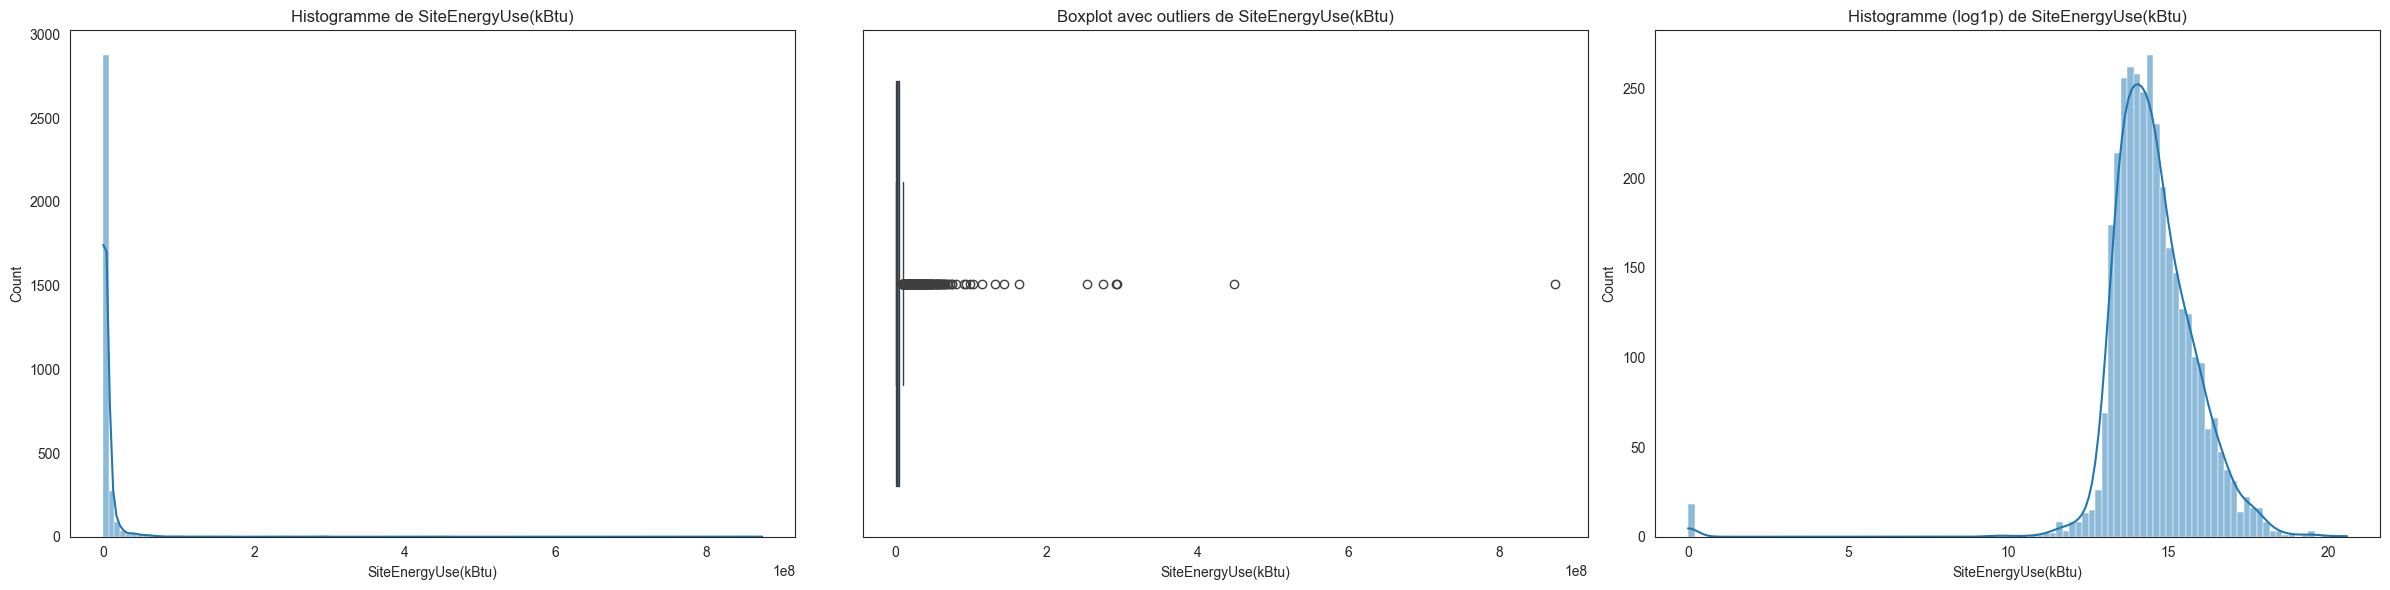

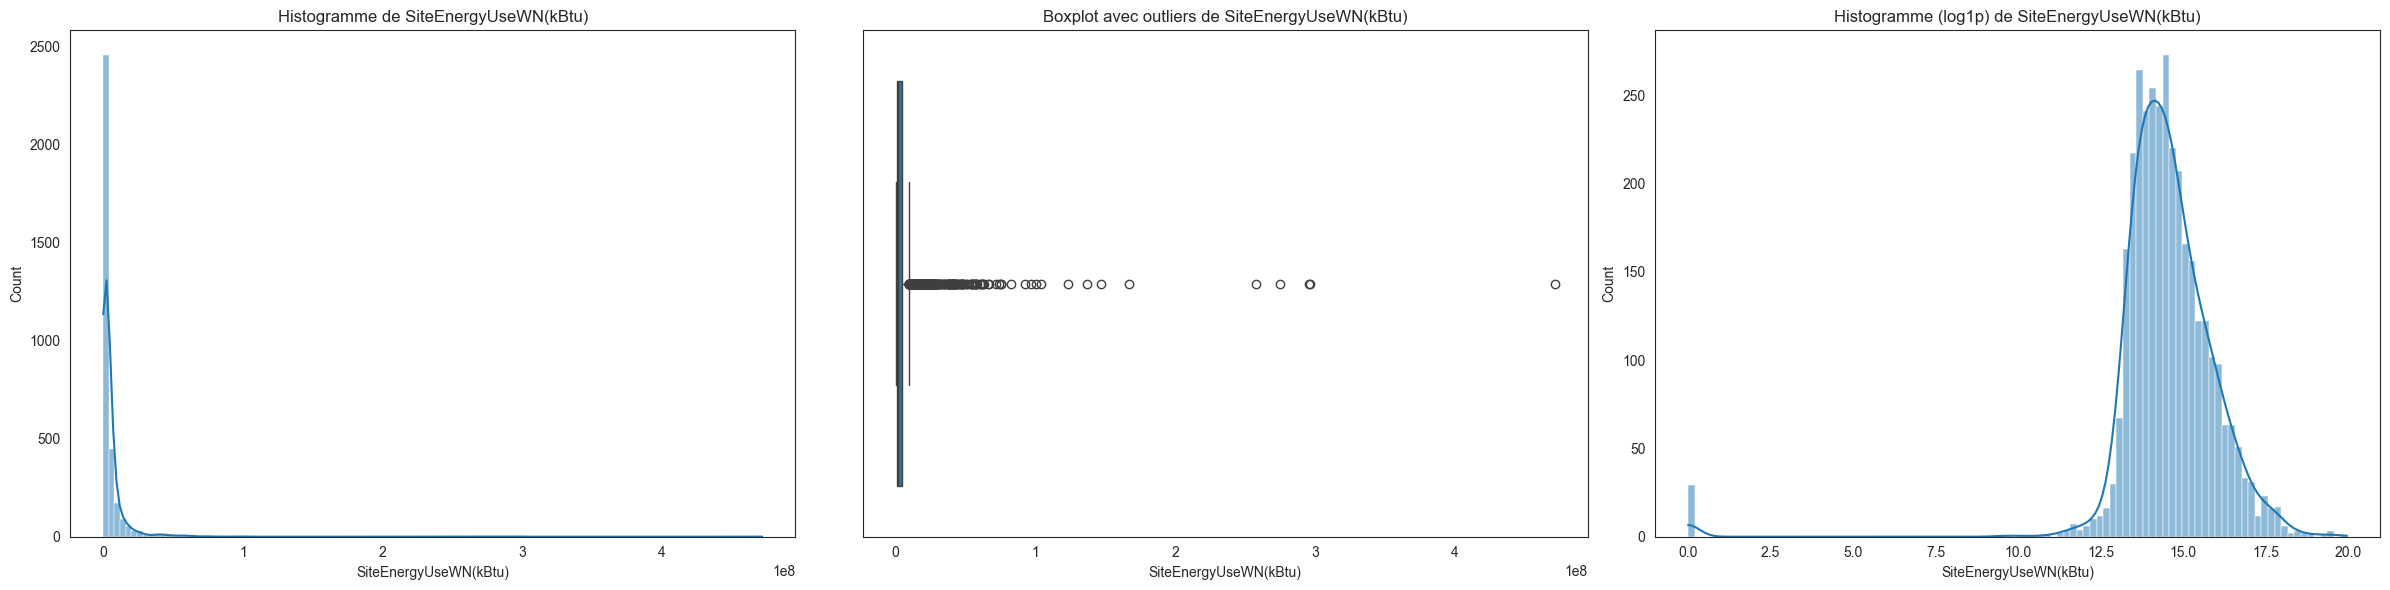

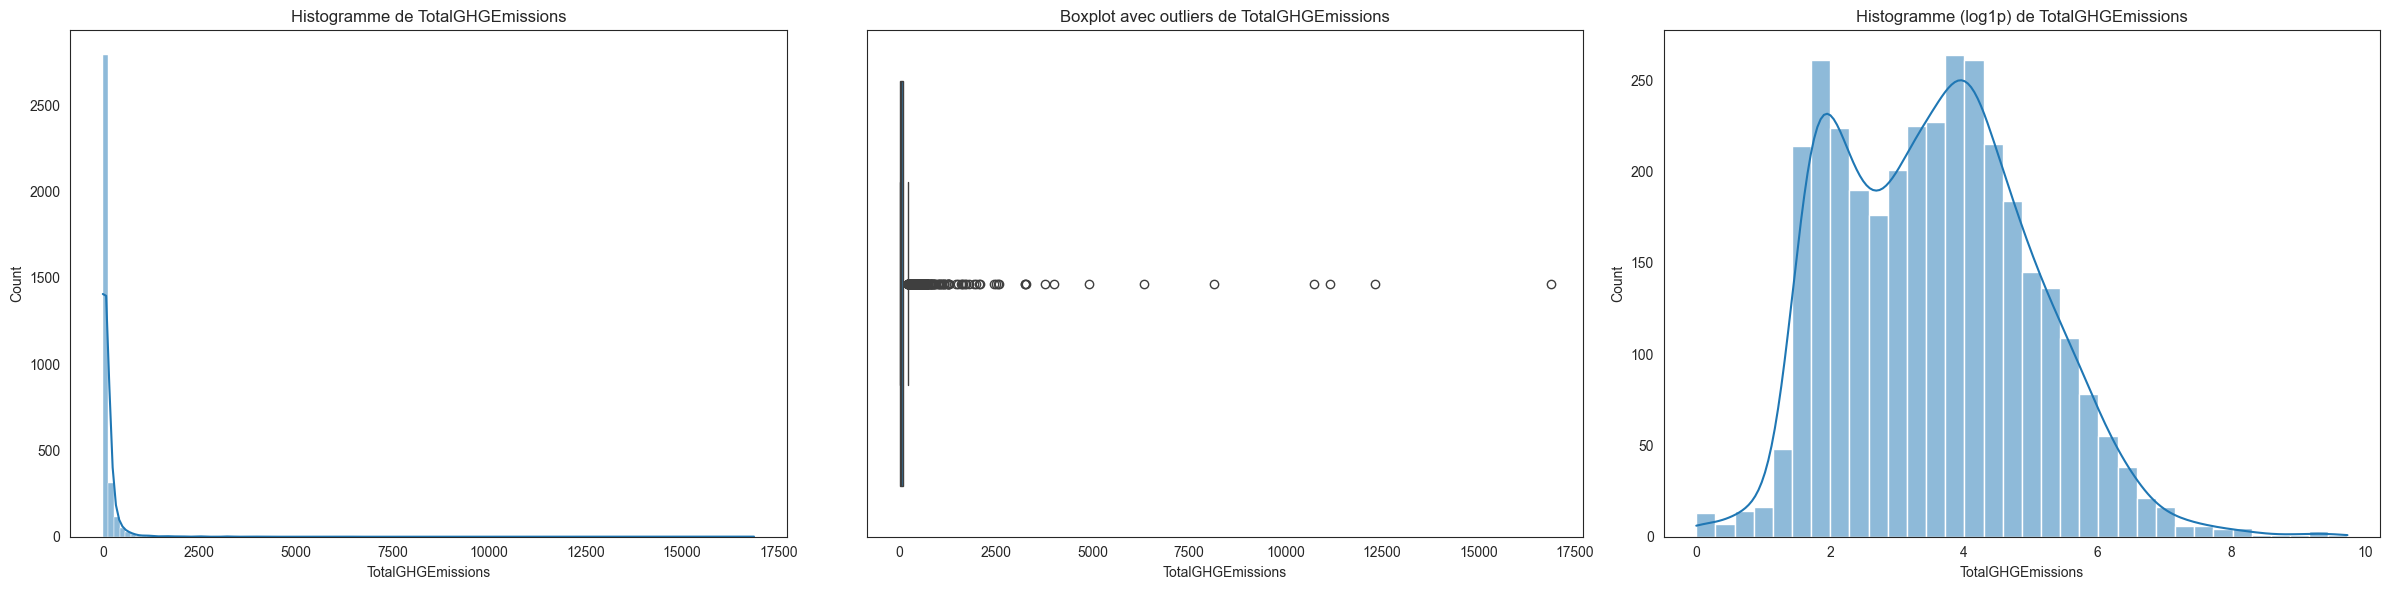

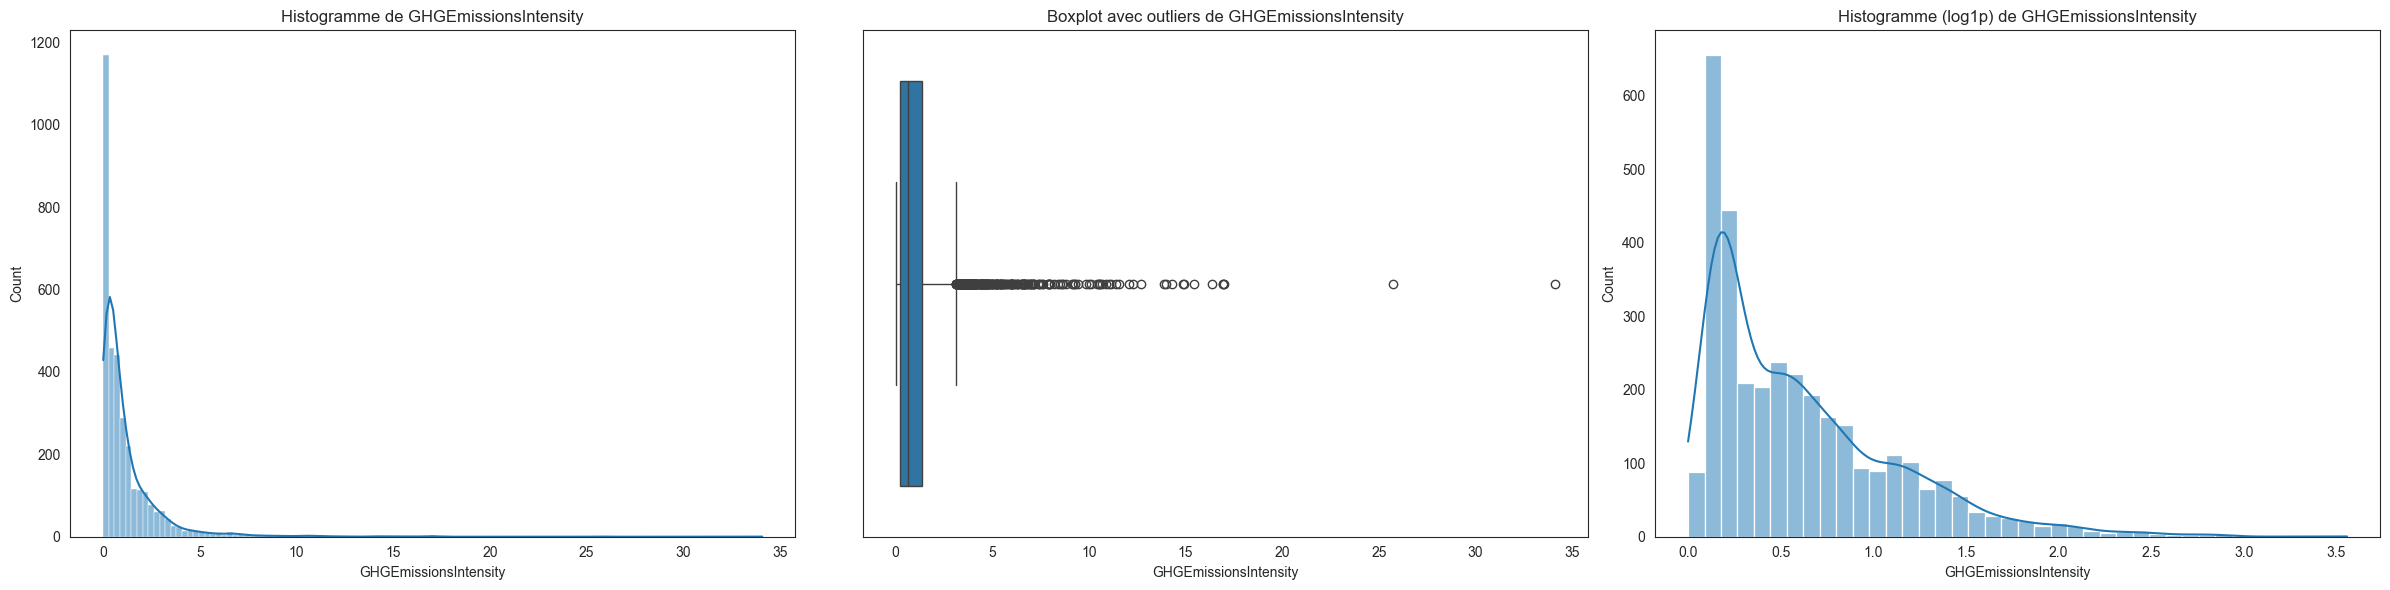

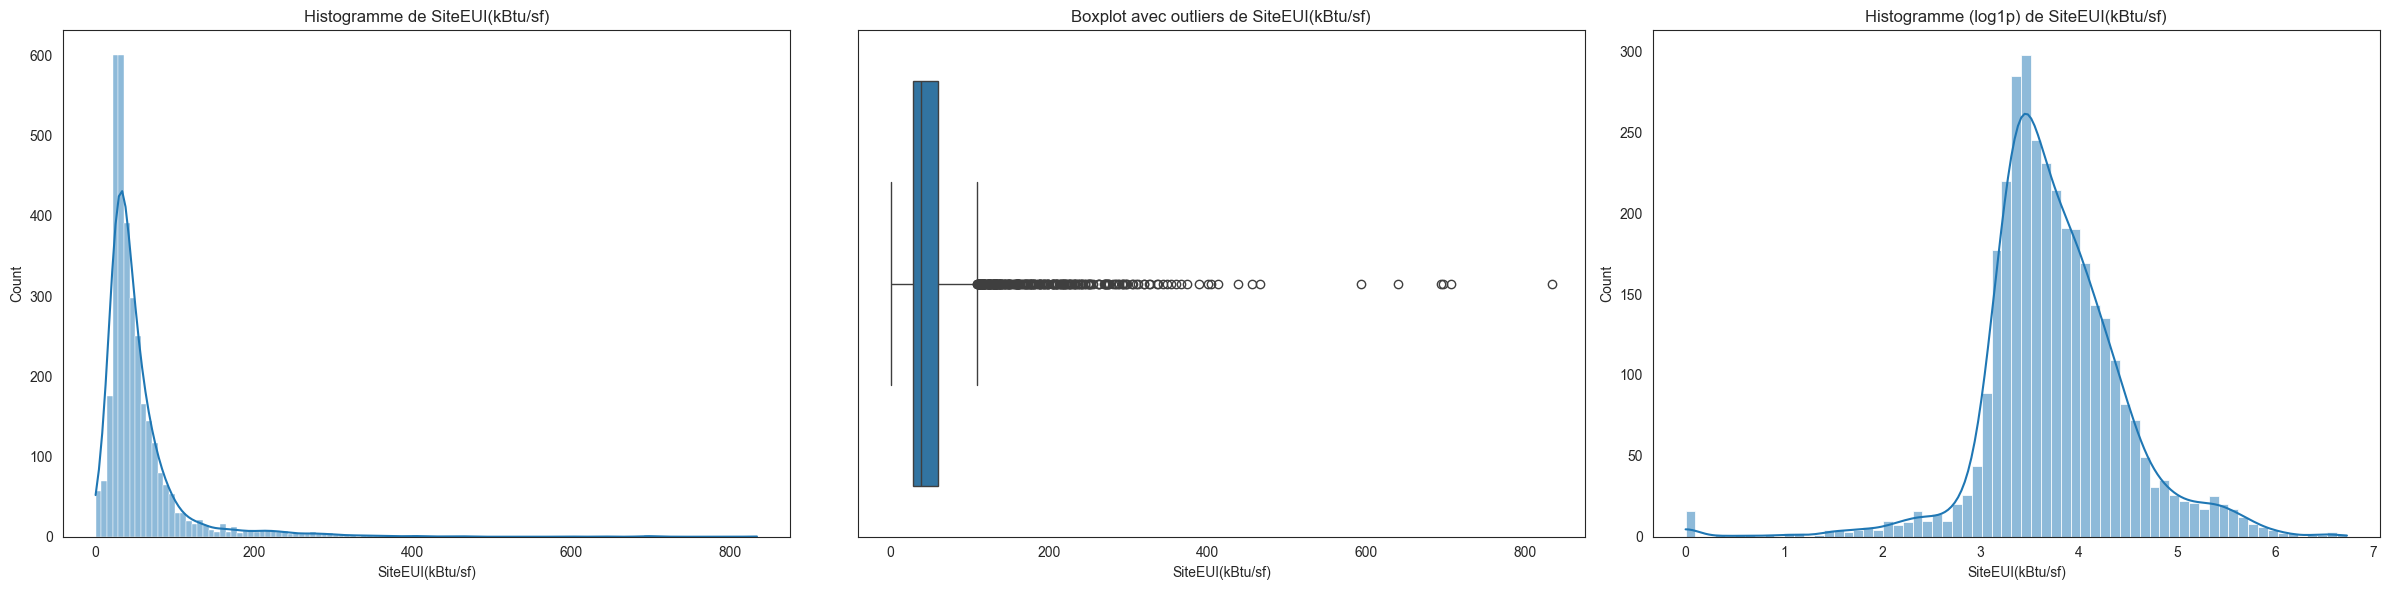

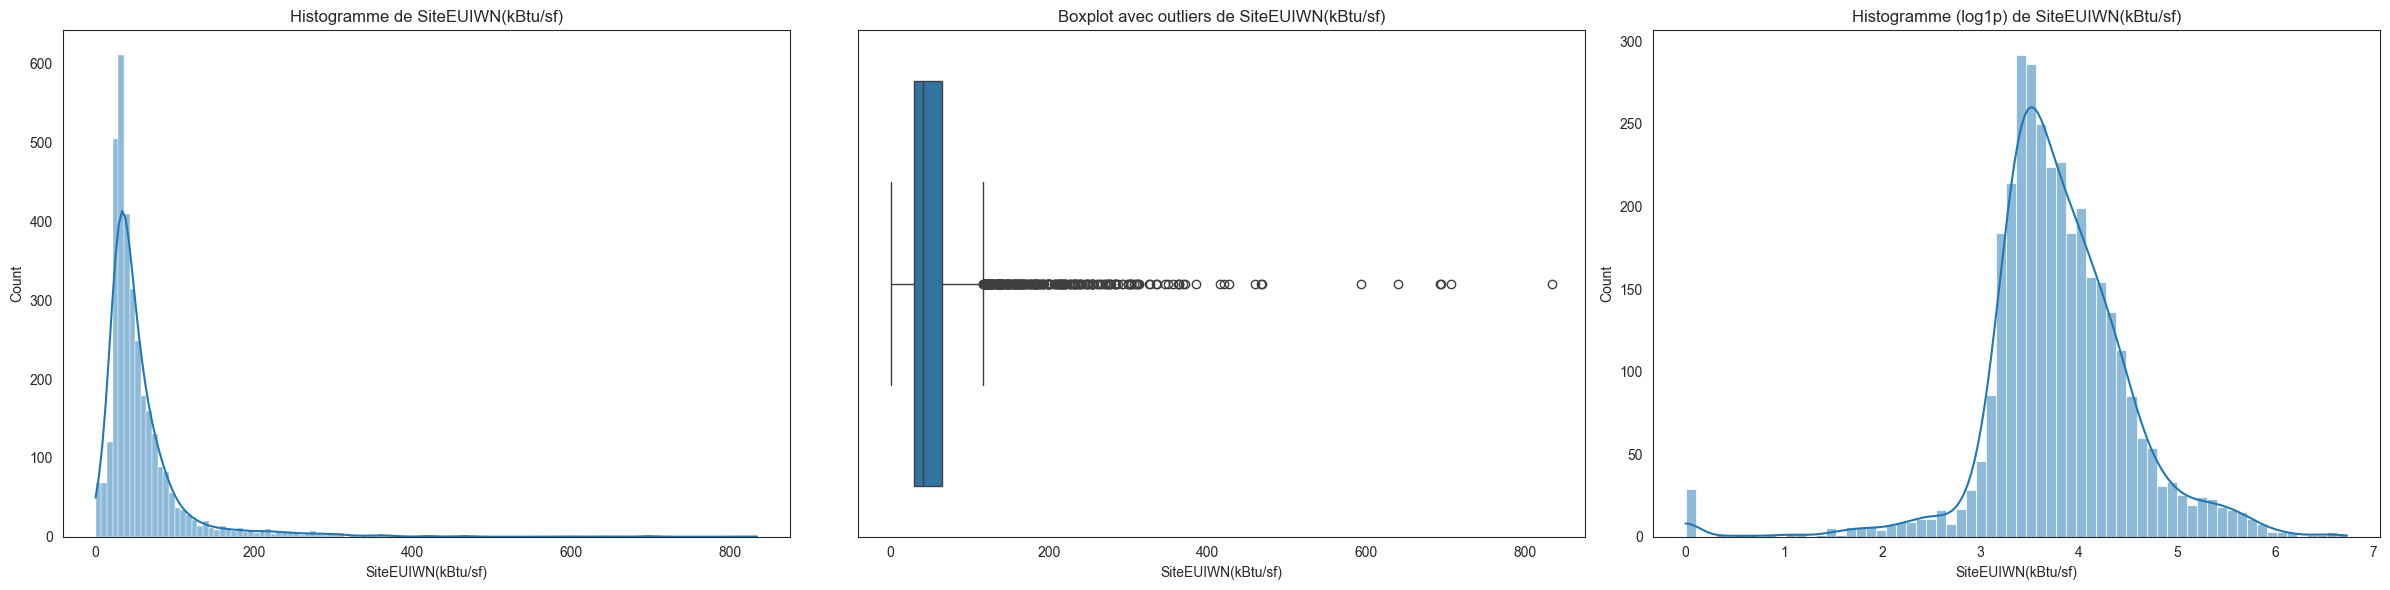

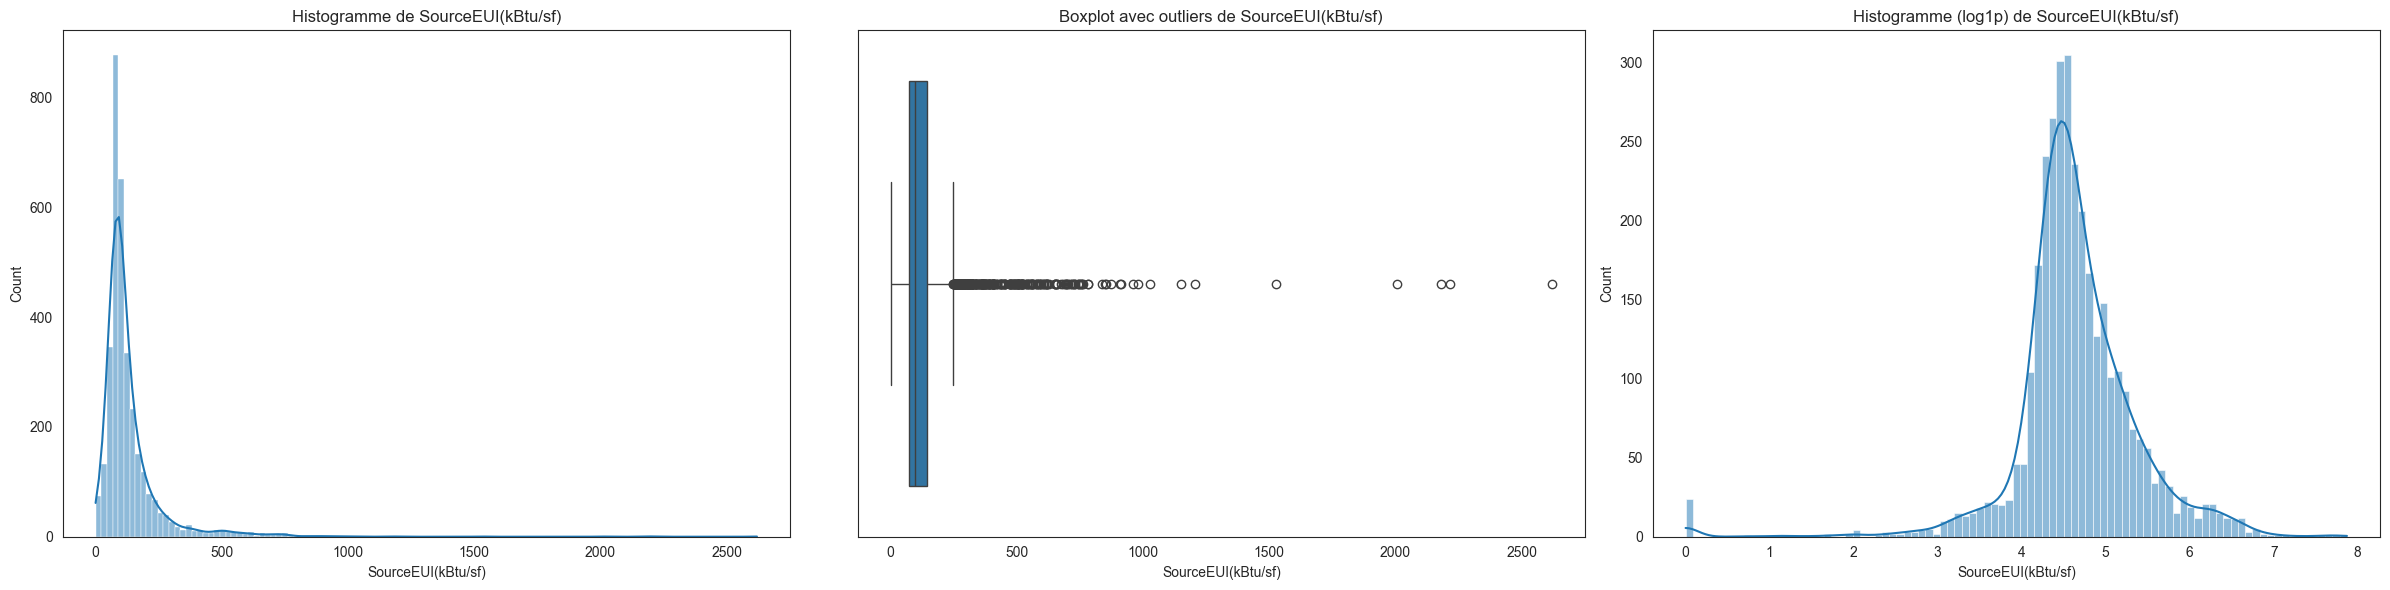

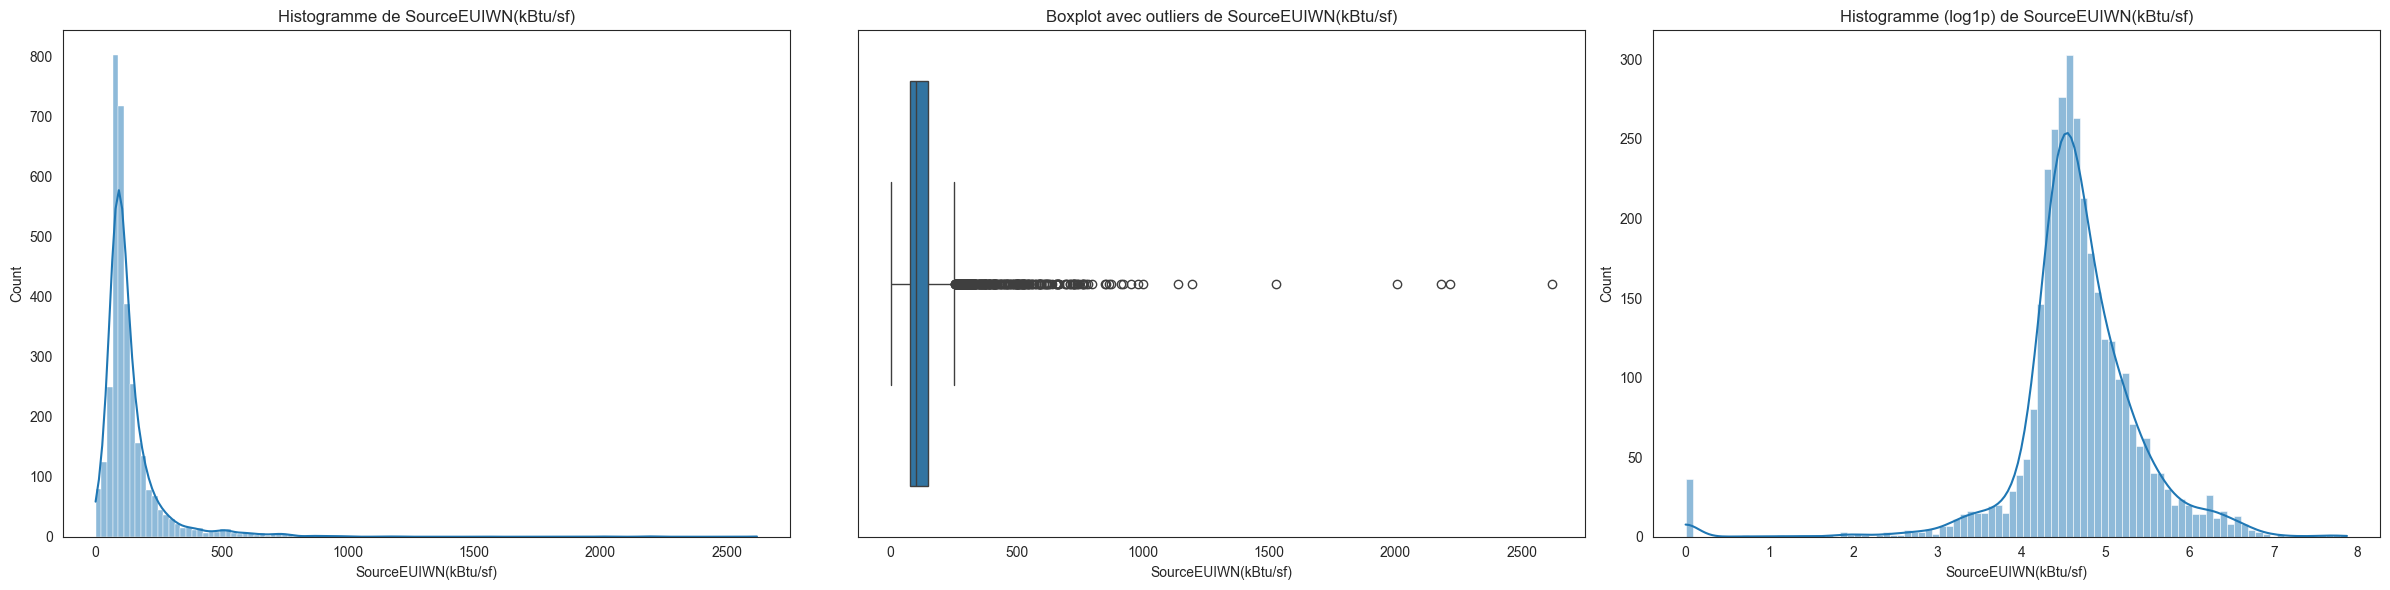

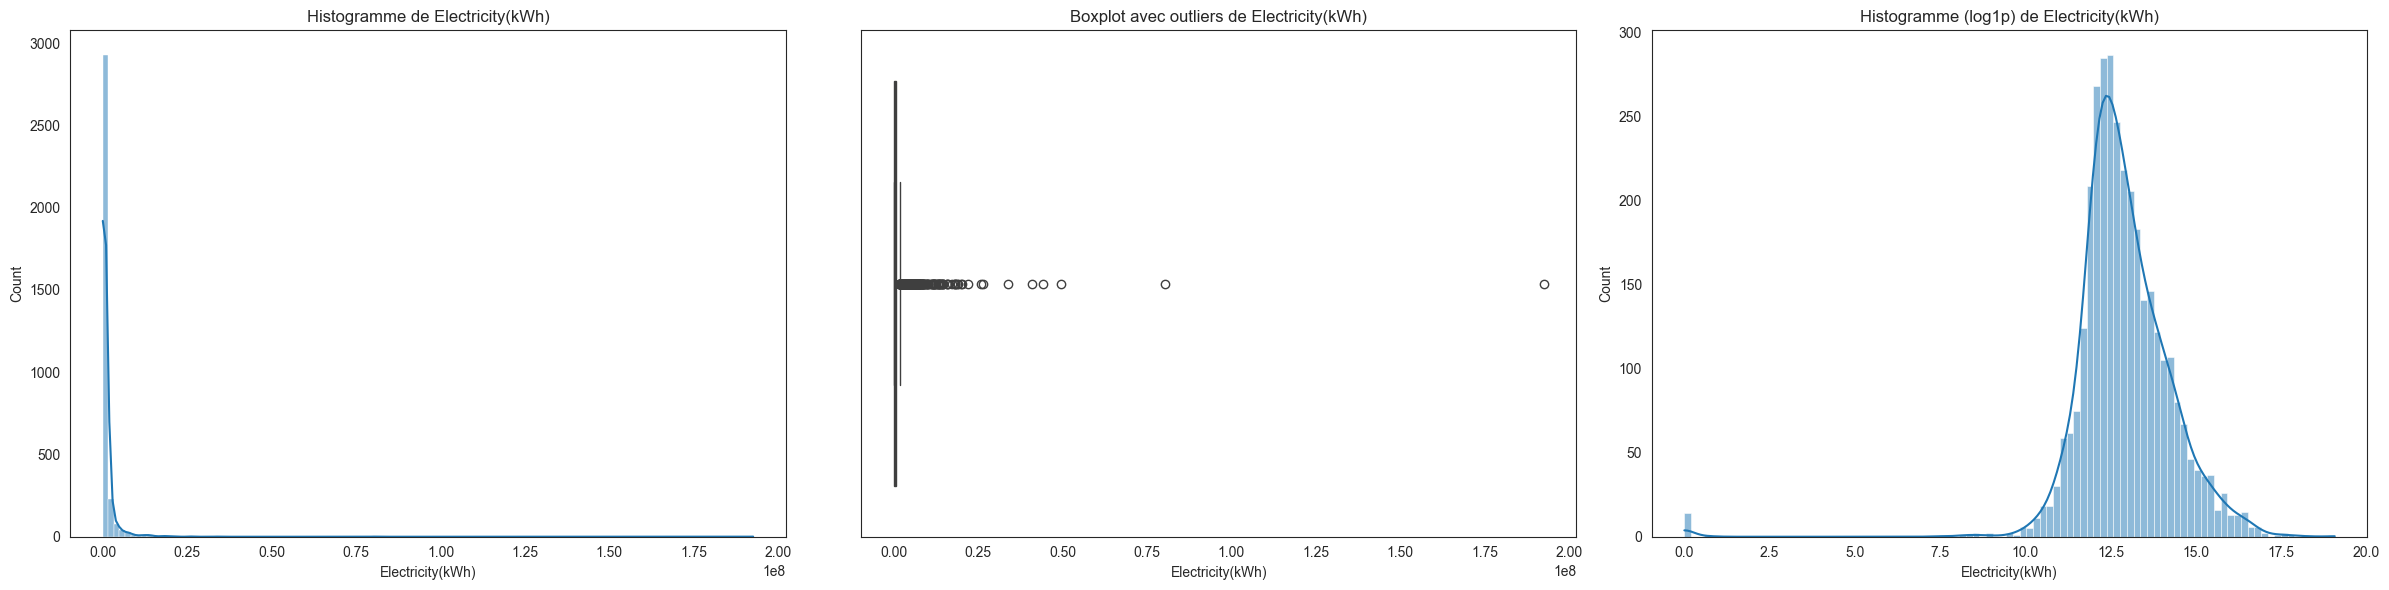

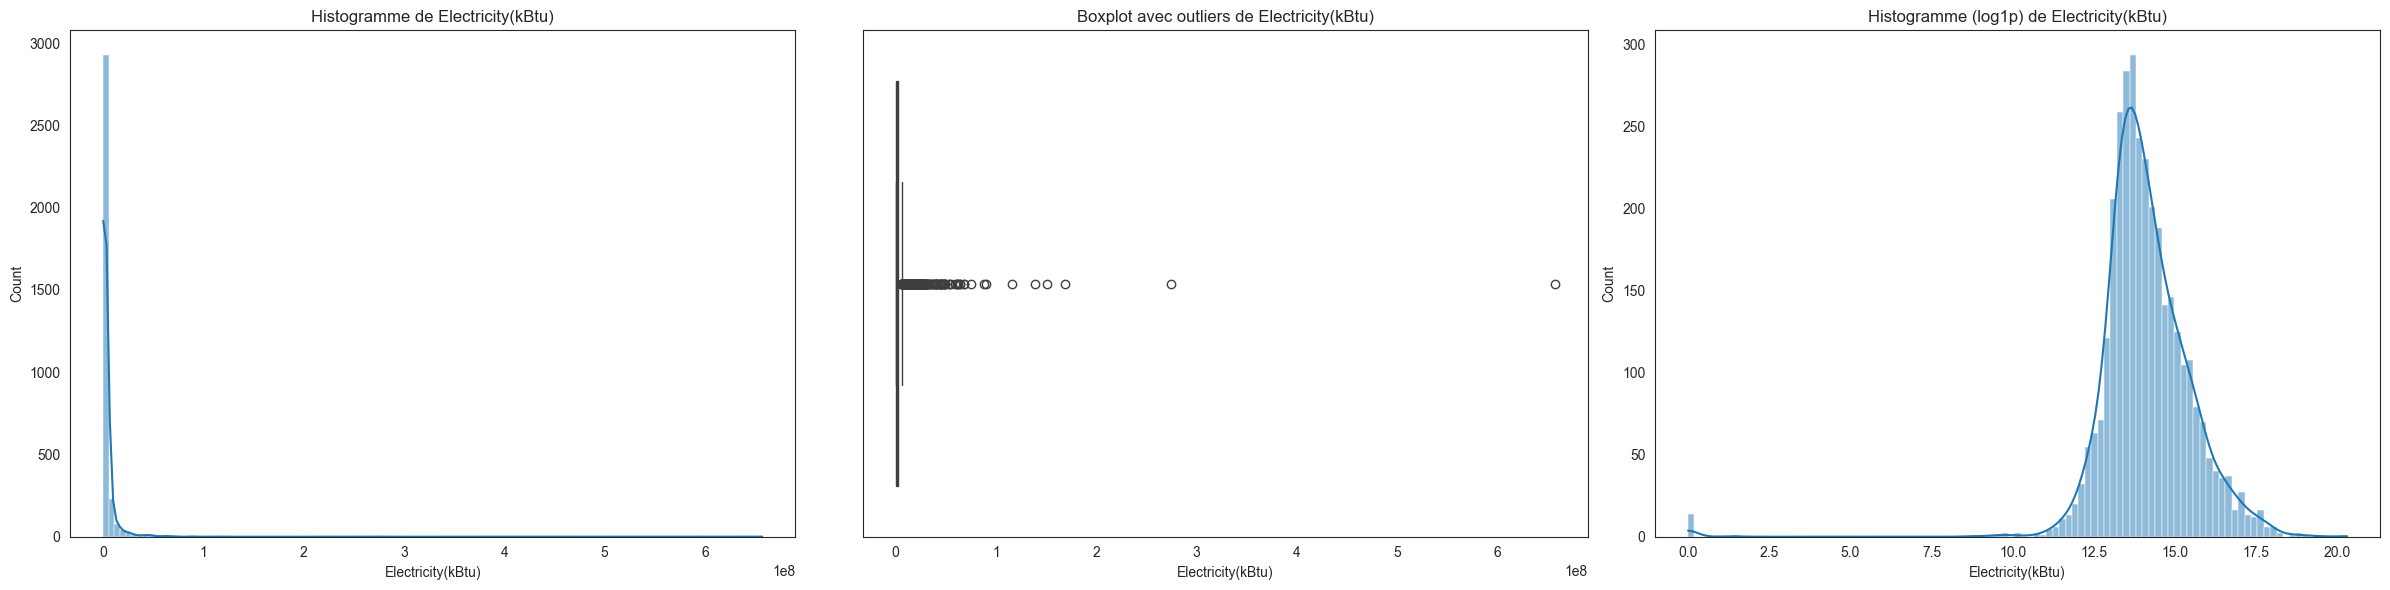

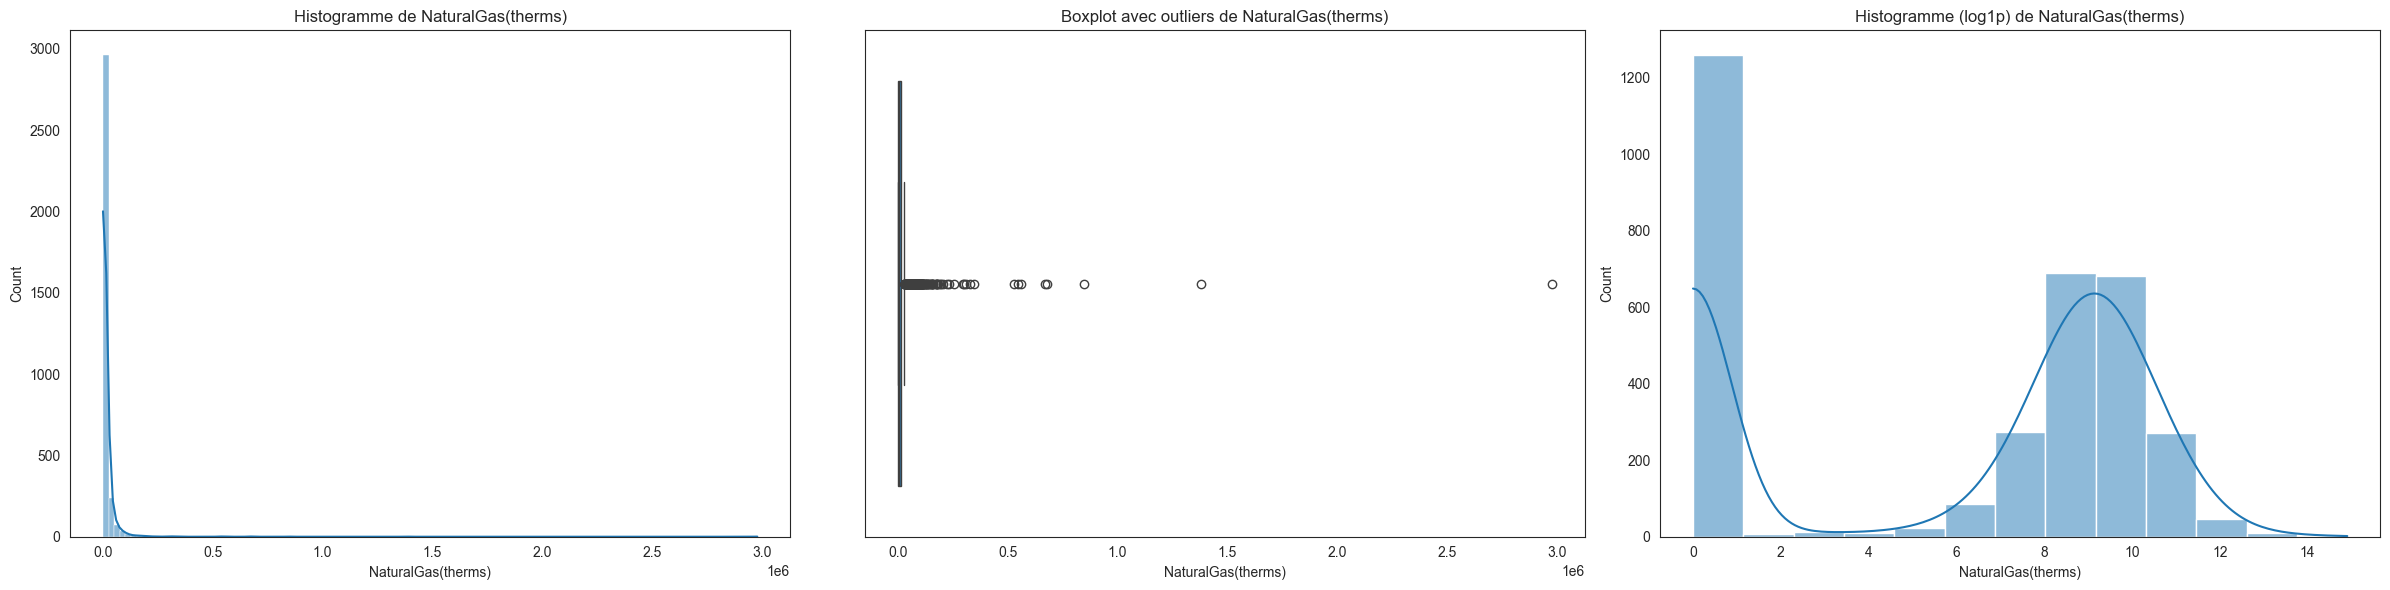

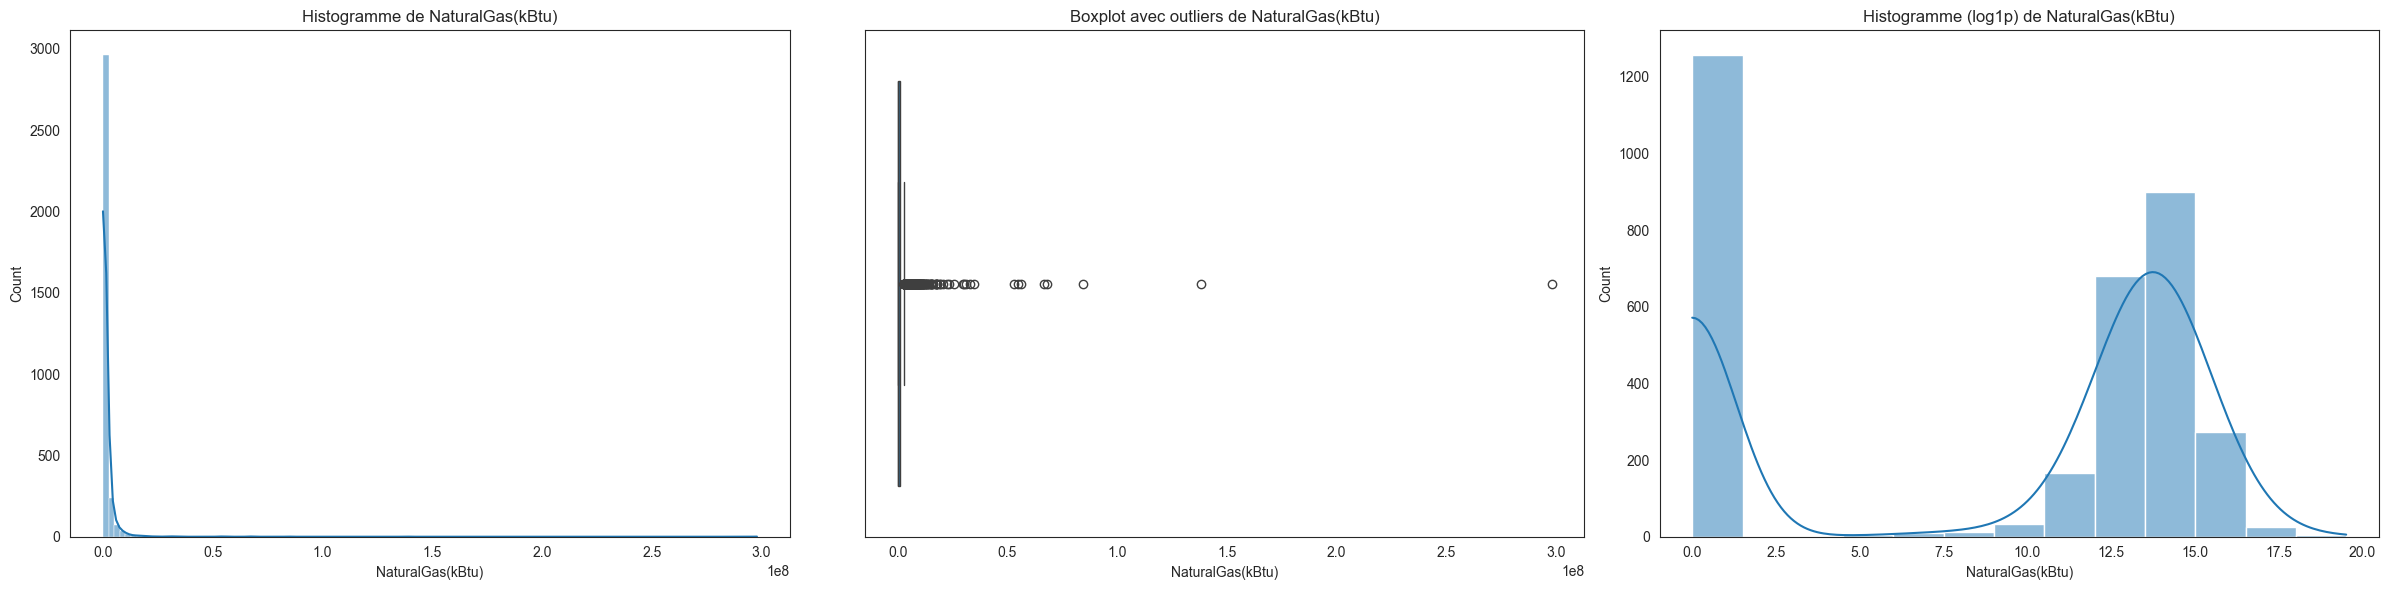

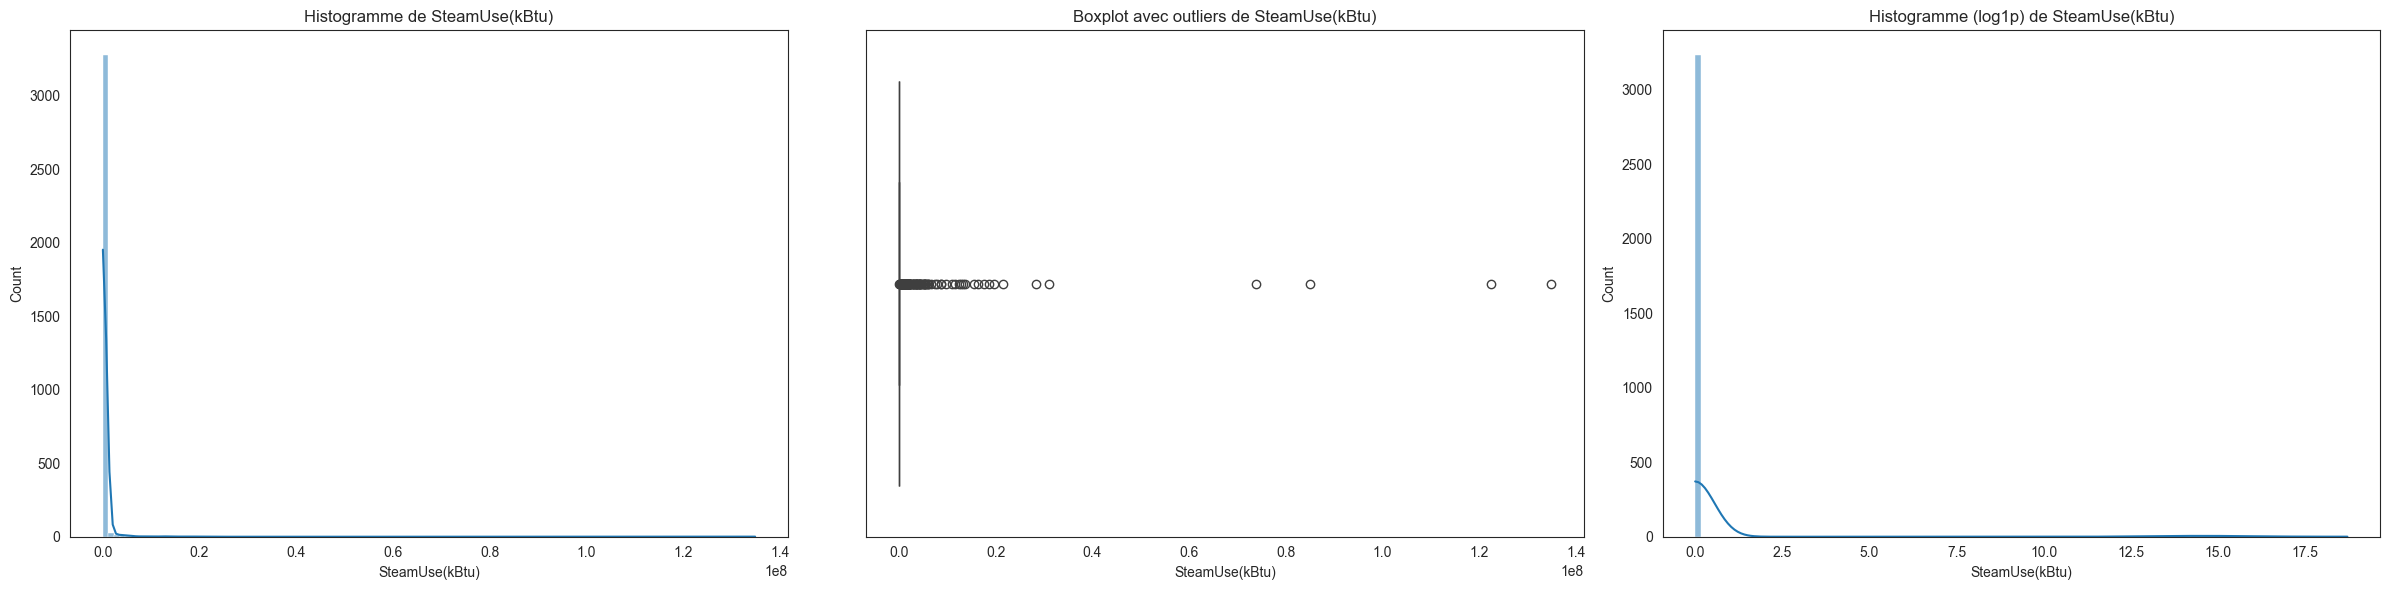

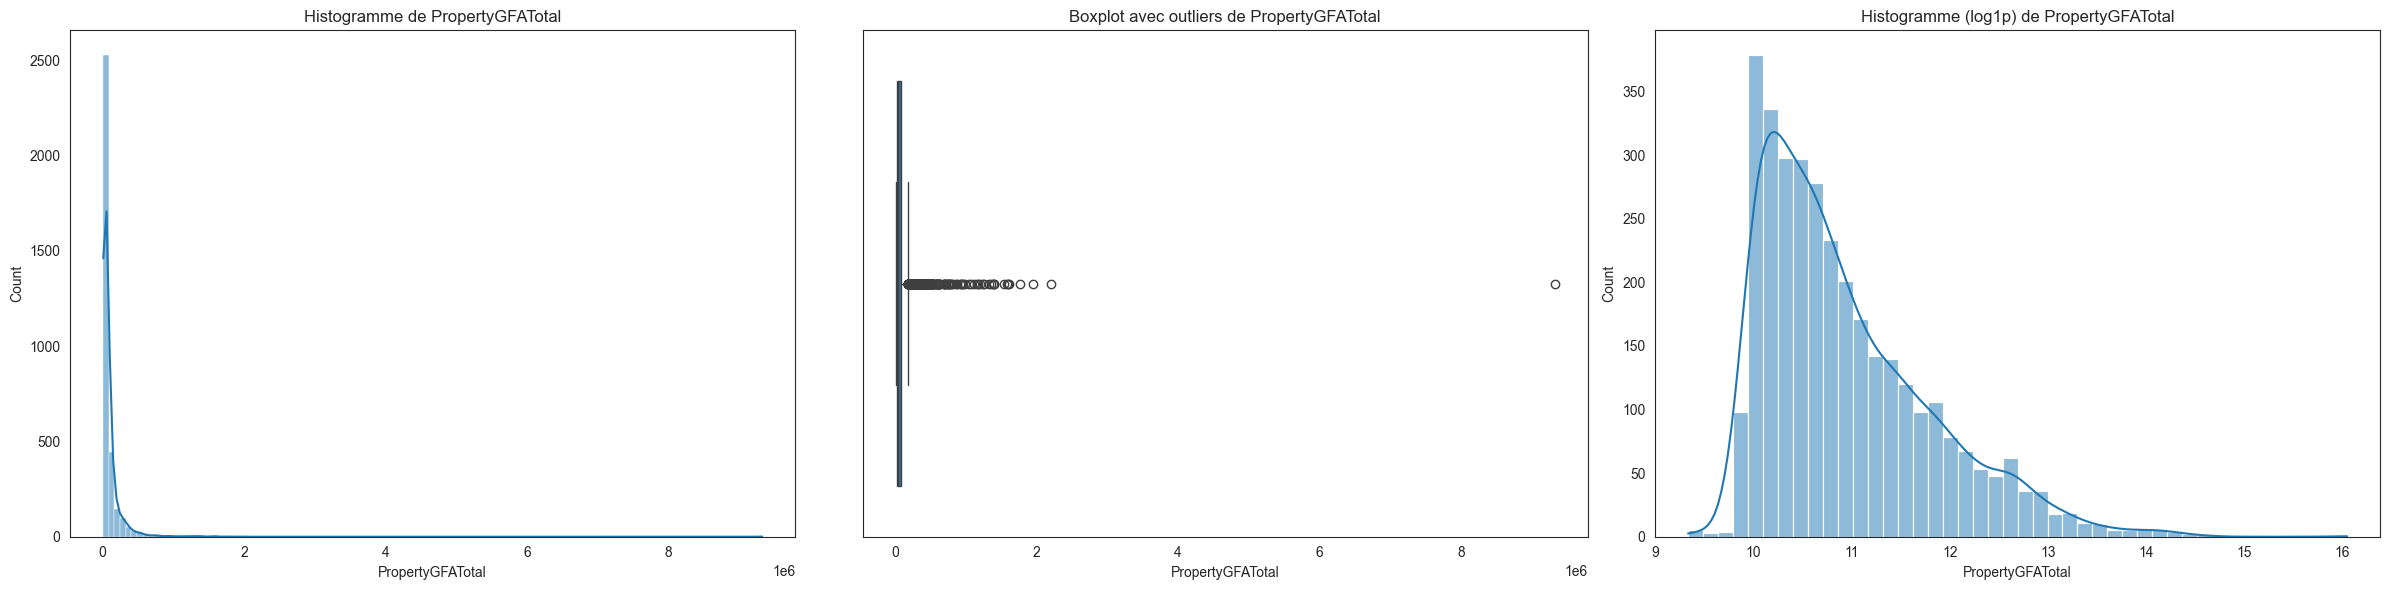

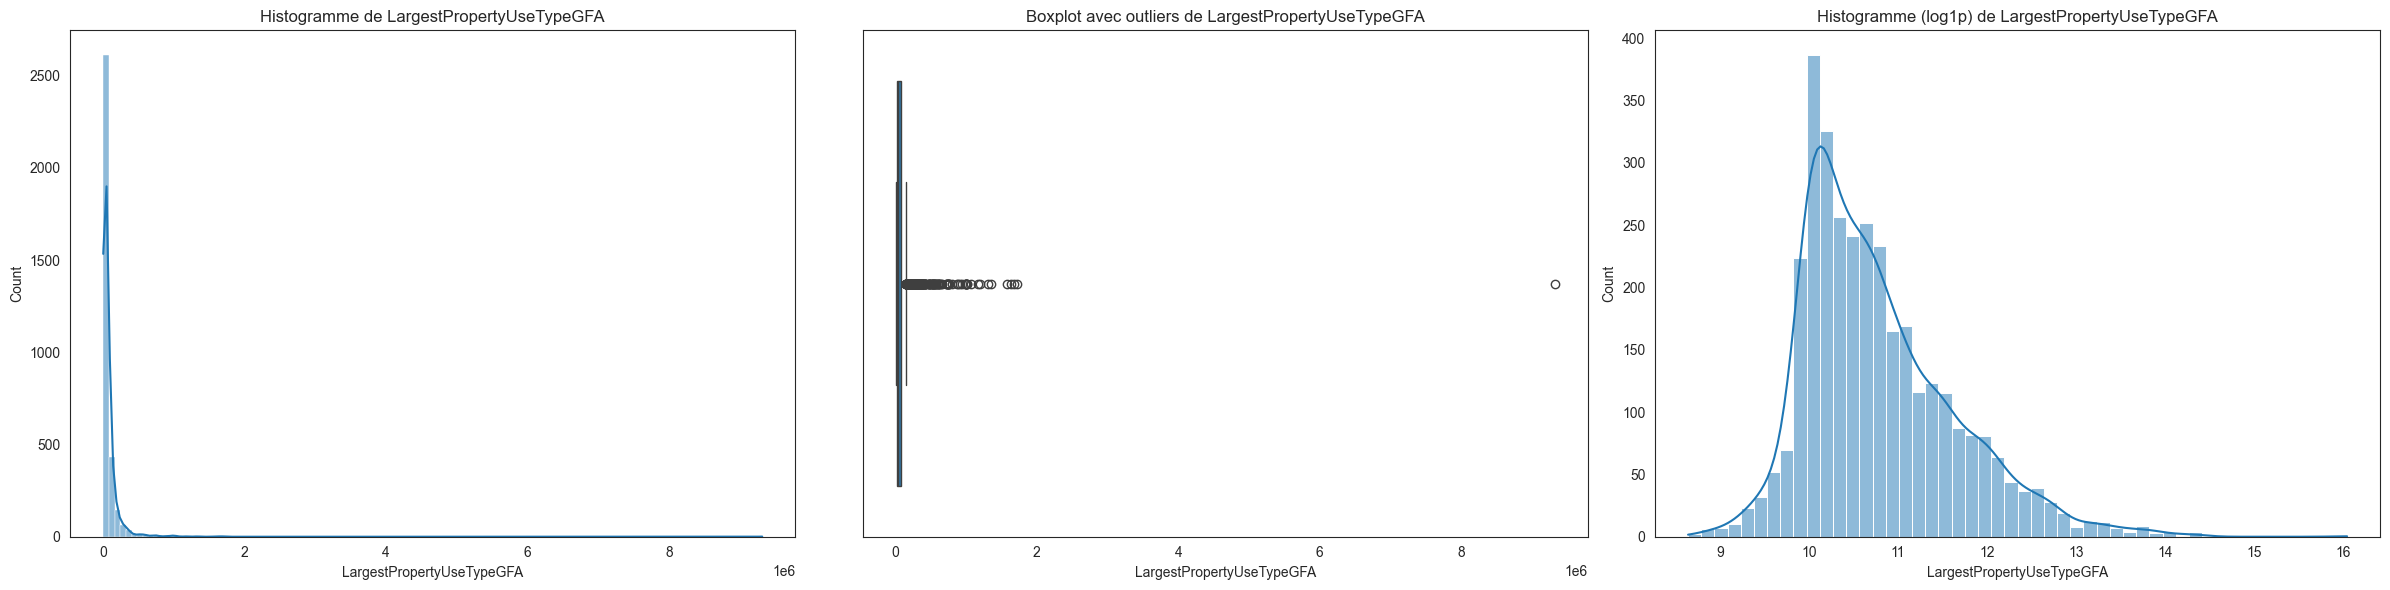

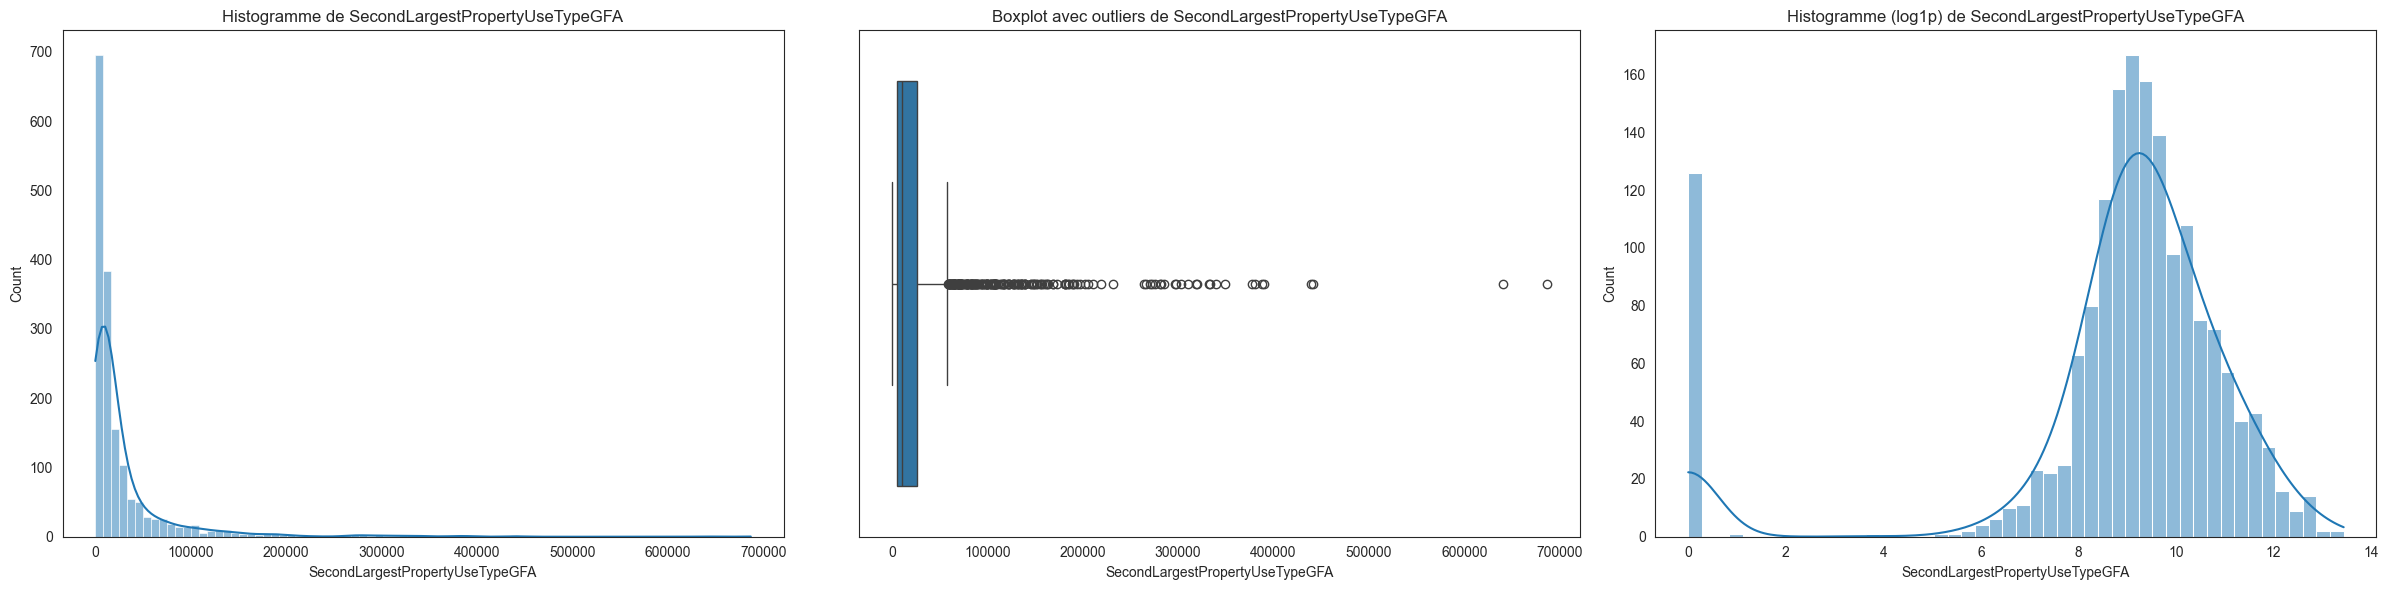

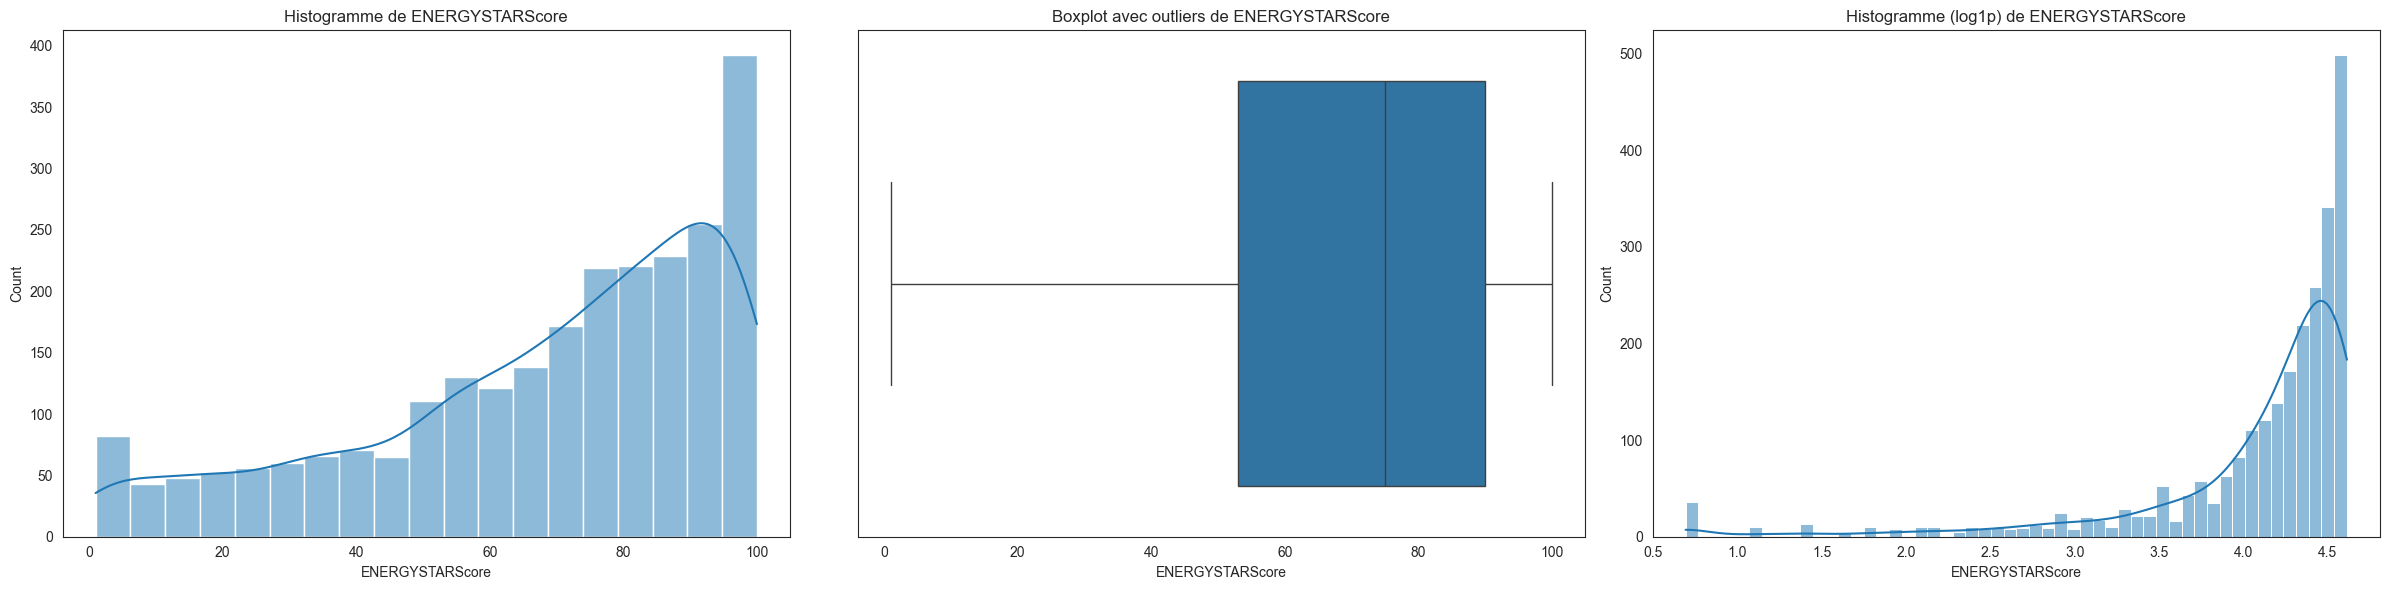

In [32]:

target_cols = [
    'SiteEnergyUse(kBtu)', 
    'SiteEnergyUseWN(kBtu)',
    'TotalGHGEmissions', 
    'GHGEmissionsIntensity', 
    
    # Intensités 
    'SiteEUI(kBtu/sf)', 
    'SiteEUIWN(kBtu/sf)', 
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)',
    
    # Détail des consommations (Sources d'erreurs fréquentes)
    'Electricity(kWh)', 
    'Electricity(kBtu)', 
    'NaturalGas(therms)', 
    'NaturalGas(kBtu)', 
    'SteamUse(kBtu)', 
    
    # Caractéristiques structurelles 
    'PropertyGFATotal', 
    'LargestPropertyUseTypeGFA', 
    'SecondLargestPropertyUseTypeGFA', 
    'ENERGYSTARScore'
]

# Filtrer les variables présentes dans le dataframe et conserver l'ordre
analyze_cols = [col for col in target_cols if col in df_raw.columns]

def plot_distributions(data, col):
    data_pos = data[data >= 0]

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Histogramme brut
    sns.histplot(data_pos, kde=True, ax=axes[0])
    axes[0].set_title(f'Histogramme de {col}')

    # Boxplot avec outliers
    sns.boxplot(x=data_pos, showfliers=True, ax=axes[1])
    axes[1].set_title(f'Boxplot avec outliers de {col}')

    # Histogramme log-transformé
    sns.histplot(np.log1p(data_pos), kde=True, ax=axes[2])
    axes[2].set_title(f'Histogramme (log1p) de {col}')

    plt.tight_layout()
    return fig


def export_figures(df, cols, output_dir="../figures/notebook_1"):
    """
    Exporte les figures générées pour chaque variable dans un dossier donné.
    """
    for idx, col in enumerate(cols, start=5):
        data = df[col].dropna()
        fig = plot_distributions(data, col)

        # Nettoyer le nom de fichier
        safe_col = re.sub(r'[^\w\-_.]', '_', col)
        filename = f"{output_dir}/{idx}_audit_indicateurs_{safe_col}.png"

        fig.savefig(filename, dpi=300)
        plt.show()


export_figures(df_raw, analyze_cols)




### Démarche pratique d’analyse des valeurs aberrantes

Pour chaque variable, l’analyse repose sur une lecture conjointe des trois graphiques.

- **Histogramme brut**  
  Sert à identifier l’asymétrie globale, la présence de longues traînes et les ordres de grandeur.
  Il permet de juger immédiatement si une méthode paramétrique comme le Z-score est envisageable
  sur la variable brute.

- **Box-plot avec outliers**  
  Sert à évaluer l’ampleur du phénomène extrême :
  nombre de valeurs extrêmes, écrasement de la boîte, distance entre la médiane et les moustaches.
  Il permet de savoir si les valeurs extrêmes sont rares ou massives,
  et si une méthode basée sur l’IQR est inadaptée appliquée directement (trop de valeurs hors boites,c'est pas bon signe).

- **Histogramme après transformation (log1p)**  
  Sert à vérifier si la transformation rend la distribution plus symétrique et exploitable.
  Si la distribution devient plus compacte et unimodale, une détection statistique
  (Z-score sur données transformées) devient pertinente.

> Dans le cas où la transformation logarithmique ne parvient pas à rendre la distribution suffisamment
symétrique ou proche d’une loi normale, deux choix s’offrent à nous.  
- Si le nombre de valeurs extrêmes reste limité, l’approche par l’IQR demeure pertinente pour isoler
ces observations atypiques.  
- En revanche, si les valeurs extrêmes sont trop nombreuses ou structurellement liées à des
caractéristiques spécifiques des bâtiments, il devient nécessaire d’examiner les distributions
par regroupement afin de contextualiser la détection
et éviter de qualifier à tort des comportements énergétiques légitimes comme aberrants.



# Tableau des variables et décisions associées

| Variable                     | Décision            |
|------------------------------|---------------------|
| SiteEnergyUse(kBtu)          | Log-transformation  |
| SiteEnergyUseWN(kBtu)        | Z-score             |
| TotalGHGEmissions            | IQR                 |
| GHGEmissionsIntensity        | Log-transformation  |
| SiteEUI(kBtu/sf)             | IQR                 |
| SiteEUIWN(kBtu/sf)           | Z-score             |
| SourceEUI(kBtu/sf)           | IQR                 |
| SourceEUIWN(kBtu/sf)         | Regroupement        |
| Electricity(kWh)             | IQR                 |
| Electricity(kBtu)            | IQR                 |
| NaturalGas(therms)           | Log-transformation  |
| NaturalGas(kBtu)             | IQR                 |
| SteamUse(kBtu)               | IQR                 |
| PropertyGFATotal             | Regroupement        |
| LargestPropertyUseTypeGFA    | IQR                 |
| SecondLargestPropertyUseTypeGFA | Regroupement     |
| ENERGYSTARScore              | Z-score             |


# Section 4 : Analyse de fiabilité

# Section 5 : Analyse de doublons


# Section 6 : Plan d'action